In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import pickle
import pathlib
import tqdm
import numpy as np
import numpy.random
import pandas as pd
from sklearn import svm
import sklearn.metrics as metr
import sklearn.preprocessing as pp
import sklearn.linear_model as lm
import sklearn.neighbors.nearest_centroid as nc
import sklearn.neighbors as ne
import sklearn.naive_bayes as nb
import sklearn.ensemble as em
import sklearn.discriminant_analysis as da
import sklearn.gaussian_process as gp
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.base import clone
import sklearn.model_selection as ms
import gestureanalysis.svm_helpers as svmhelper
import sklearn.feature_selection as fs
import sklearn.utils
import matplotlib.pyplot as plt
import seaborn as sns
from gestureanalysis.constants import Constants
from gestureanalysis.fit_utils import fit_classifier
from gestureanalysis.sensor_utils import *
from functools import partial

In [3]:
base_path = "/home/jsimon/Documents/thesis/gesture-analysis/data/"
time_groups_path_corrected_pickl = base_path+"transformed/time_added/all/time-and-groups-corrected-all.pkl"
stats_added_base_path = base_path+"transformed/stats_added/all/"
stats_added_path_pickl = stats_added_base_path+"raw_stats-added-all.pkl"
gyro_calibration_path = base_path+'../scripts/gestureanalysis/gyro_offset.txt'

In [4]:
import os
os.getcwd()

'/home/jsimon/Documents/thesis/gesture-analysis/scripts'

## List of Classifiers to test with

In [5]:
# start with some list, and remove then when the classifier takes too long
classifiers = [("passive agressive", lm.PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, class_weight='balanced', n_jobs=3)),
               ("sgd[hinge]",lm.SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, tol=1e-3, class_weight='balanced', n_jobs=3)),
               ("LDA", da.LinearDiscriminantAnalysis()),
               ("QDA", da.QuadraticDiscriminantAnalysis()),
               ("nn",nc.NearestCentroid()),
               #("knn",ne.KNeighborsClassifier(n_jobs=3)),
               ("gaussian navie bayse",nb.GaussianNB()),
               ("decision tree",tree.DecisionTreeClassifier(class_weight='balanced')), # timed out
               ("random forrest",em.RandomForestClassifier(n_estimators=10, class_weight='balanced', n_jobs=3, verbose=True)),
               ("extra trees",em.ExtraTreesClassifier(n_estimators=10, class_weight='balanced', n_jobs=3, verbose=True)),
               ("ada boost",em.AdaBoostClassifier(n_estimators=100)),
               #("gradient boost",em.GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0, verbose=True)) # timed out, says after 1h running that it still has 400 open
]

In [7]:
with open( stats_added_base_path+'train-data-rfecv2.pk', "rb" ) as users_pickle_file:
    data = pickle.load(users_pickle_file)
Xrfe = data['X']
y = data['y']
XValrfe = data['Xval']
yval = data['yval']
gestures = data['gestures']
rfe_features = data['headers']

In [23]:
def select_sensors_with_cost(alpha, X, y, Xval, yval, cost_per_sensor, mod_cost_callback, features, normalizer, classifiers, fit_classifier, results):
    if len(features.flatten()) <= 1:
        print("done")
        return
    sensors, featuremap = sensor_array(features, normalizer=normalizer)
    if len(sensors[sensors > 0].flatten()) <= 0:
        print("done")
        return
    cost_per_sensor = mod_cost_callback(sensors, cost_per_sensor)
    sensors = np.multiply((1. - sensors), cost_per_sensor)
    #sensors = np.multiply(sensors, cost_per_sensor)
    idx, value = weakest_idx(sensors.flatten())
    print(f"sensor removed: {idx}")
    print(f"sensors inclusive removed: {sensors}")
    features_to_remove = featuremap[idx]
    indices = [i for i, x in enumerate(features) if x not in features_to_remove]
    X = X[:,indices]
    Xval = Xval[:,indices]
    features = features[indices]
    
    r = fit_classifier(classifiers, X, y, Xval, yval)
    b = best_classifier(r)
    results.append({
        'sensors' : sensors,
        'features' : features,
        'best_classifier' : b
    })
    
    linc = sklearn.linear_model.Lasso(alpha = alpha, max_iter=2000, tol=1e-3)
    linc.fit(X, y)
    rfecv = fs.RFECV(estimator=linc, cv=5, step=0.05, verbose=2)
    rfecv.fit(X, y)
    col_index = rfecv.get_support(indices=True)
    X = X[:,col_index]
    Xval = Xval[:,col_index]
    features = features[col_index]
    select_sensors_with_cost(alpha, X, y, Xval, yval, cost_per_sensor, mod_cost_callback, features, normalizer, classifiers, fit_classifier, results)

## run this only one time to generate the normalizer

In [9]:
with open( stats_added_base_path+'train-data-scaled-noconst.pkl', "rb" ) as users_pickle_file:
    data = pickle.load(users_pickle_file)

In [10]:
allfeatures = data['headers']
print(f"we have {len(allfeatures.flatten())}, f.e. {allfeatures[0,[0,200,500,600]]}")

we have 6368, f.e. ['0_0_Thumb_base_mean' '3_23_Finger_1_base_fft_mode'
 '8_28_Finger_3_tip_ff3' '10_10_Finger_4_tip_kurtosis']


In [11]:
normalizer, features = sensor_array(allfeatures.flatten())

In [12]:
normalizer

array([[ 95.],
       [ 59.],
       [ 59.],
       [ 95.],
       [ 95.],
       [ 95.],
       [ 95.],
       [ 95.],
       [ 95.],
       [ 95.],
       [ 95.],
       [ 95.],
       [ 59.],
       [ 59.],
       [ 59.],
       [ 59.],
       [ 59.],
       [ 59.],
       [590.],
       [852.],
       [826.],
       [826.],
       [826.],
       [734.],
       [472.],
       [  0.]])

In [29]:
with open( stats_added_base_path+'sensor-selection-rel-normalizer.pkl', "wb" ) as users_pickle_file:
    pickle.dump(normalizer, users_pickle_file)

In [13]:
with open( stats_added_base_path+'sensor-selection-rel-normalizer.pkl', "rb" ) as users_pickle_file:
    normalizer = pickle.load(users_pickle_file)

## Costs per sensor

If we assume a cost of 1 for each sensor, we are back to the original algorithm

In [14]:
cost_per_sensor = np.ones((26,1))

In [22]:
def mod_costs(sensors, costs): return costs

Sensors really cost different amound of money. We can carefully design that vector. The cost vector is the hardware cost per sensor + the cost of integrating the sensors. What we can not account for is if one type of sensor is differently hard to integrate depending of how many of them are there. This can be done by extending the algorithm to modify the cost at each iteration depending on how many sensors are there. You start with the high costs of integrating all and then reduce it. An example are analog sensors like flex and pressure sensors. A certain amound of them can be directly connected to an arduino. If it is over this amound you need ot build an analog multiplexer.

I assume that integrating
- analog : 0.5h * 100 = 50€
- i2c: 2h * 100 = 200€
- multiplex: 5h = 500€ / number of analog sensors if > 7

In [15]:
hour_rate = 100
analog_cost = 0.5 * hour_rate
i2c_cost = 2 * hour_rate
multiplexer_cost = 5 * hour_rate
multi_cost_per_analog = multiplexer_cost / 16 # just used at start

In [16]:
cost_per_sensor = np.zeros((26,1))

In [17]:
# pressure sensor:
pressure_sensor_cost = 7
cost_per_sensor[[1,12,13,14,15]] = pressure_sensor_cost + analog_cost + multi_cost_per_analog

In [18]:
# flex sensor: did cost approx 7€. Easy to integrate since it is only an analog connecten,
# unless there are more than 7 of them. Easy integration is 
flex_sensor_cost = 10
cost_per_sensor[[0,2,3,4,5,6,7,8,9,10,11]] = flex_sensor_cost + analog_cost + multi_cost_per_analog

In [19]:
# IMU cost
flex_sensor_cost = 18
cost_per_sensor[list(range(16,25))] = flex_sensor_cost + i2c_cost

In [20]:
# magnetometer cost
flex_sensor_cost = 12
cost_per_sensor[25] = flex_sensor_cost + i2c_cost

In [21]:
cost_per_sensor.shape

(26, 1)

In [17]:
cost_total_ps_alphaed = 1 - (cost_per_sensor / (cost_per_sensor.max() + 50))

In [18]:
cost_total_ps_alphaed

array([[0.65951493],
       [0.67070896],
       [0.65951493],
       [0.65951493],
       [0.65951493],
       [0.65951493],
       [0.65951493],
       [0.65951493],
       [0.65951493],
       [0.65951493],
       [0.65951493],
       [0.65951493],
       [0.67070896],
       [0.67070896],
       [0.67070896],
       [0.67070896],
       [0.18656716],
       [0.18656716],
       [0.18656716],
       [0.18656716],
       [0.18656716],
       [0.18656716],
       [0.18656716],
       [0.18656716],
       [0.18656716],
       [0.20895522]])

In [17]:
cost_ps_normalized = 1 - (cost_per_sensor/cost_per_sensor.sum())

In [18]:
cost_ps_alpha2ed = 2 * cost_ps_normalized

In [19]:
cost_ps_alpha4ed = 4 * cost_ps_normalized

In [20]:
cost_ps_alpha10ed = 10 * cost_ps_normalized

In [21]:
cost_ps_alpha100ed = 50 * cost_ps_normalized

In [23]:
cost_ps_normalized

array([[0.97478585],
       [0.97561481],
       [0.97478585],
       [0.97478585],
       [0.97478585],
       [0.97478585],
       [0.97478585],
       [0.97478585],
       [0.97478585],
       [0.97478585],
       [0.97478585],
       [0.97478585],
       [0.97561481],
       [0.97561481],
       [0.97561481],
       [0.97561481],
       [0.93976237],
       [0.93976237],
       [0.93976237],
       [0.93976237],
       [0.93976237],
       [0.93976237],
       [0.93976237],
       [0.93976237],
       [0.93976237],
       [0.94142028]])

In [60]:
def mod_costs(sensors, costs):
    analog = sensors[:16]
    na = len(np.where(analog>0.0)[0])
    if na > 7:
        multi_cost_per_analog = multiplexer_cost / na
        costs[[1,12,13,14,15]] = pressure_sensor_cost + analog_cost + multi_cost_per_analog
        costs[[0,2,3,4,5,6,7,8,9,10,11]] = flex_sensor_cost + analog_cost + multi_cost_per_analog
    else:
        costs[[1,12,13,14,15]] = pressure_sensor_cost + analog_cost
        costs[[0,2,3,4,5,6,7,8,9,10,11]] = flex_sensor_cost + analog_cost

In [10]:
with open( stats_added_base_path+'train-data-rfecv2.pk', "rb" ) as users_pickle_file:
    data = pickle.load(users_pickle_file)
Xrfe = data['X']
y = data['y']
XValrfe = data['Xval']
yval = data['yval']
gestures = data['gestures']
rfe_features = data['headers']

In [ ]:
results=[]
select_features(0.5, Xrfe, y, XValrfe, yval, cost_per_sensor, mod_costs, rfe_features.flatten(), normalizer, classifiers, fit_classifier, results)

sensor removed: 12
sensors inclusive removed: [[ 74.92105263]
 [ 86.75423729]
 [ 68.05084746]
 [ 71.07894737]
 [ 73.        ]
 [ 70.11842105]
 [ 76.84210526]
 [ 84.52631579]
 [ 84.52631579]
 [ 76.84210526]
 [ 70.11842105]
 [ 82.60526316]
 [ 52.35169492]
 [ 82.26694915]
 [ 79.27542373]
 [ 65.81355932]
 [125.62711864]
 [155.18644068]
 [204.69830508]
 [184.7370892 ]
 [198.99757869]
 [191.8716707 ]
 [209.55447942]
 [182.35967302]
 [197.21610169]
 [         nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.9146459747817652 for passive agressive (test: 0.9038397113773998)
val score 0.9020368574199806 for sgd[hinge] (test: 0.9192758665120474)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.9182023924991918 for LDA (test: 0.9177683288236052)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.9214354995150339 for QDA (test: 0.7383584589614739)
val score 0.24086647268024572 for nn (test: 0.5295967014559979)
val score 0.6745877788554802 for gaussian navie bayse (test: 0.7641154490400722)
val score 0.9212738441642419 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    9.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9523116715163272 for random forrest (test: 0.9973972426233733)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished


val score 0.9571613320400906 for extra trees (test: 1.0)
val score 0.0691884901390236 for ada boost (test: 0.536631877335395)

Fitting estimator with 741 features.
Fitting estimator with 704 features.
Fitting estimator with 667 features.
Fitting estimator with 630 features.
Fitting estimator with 593 features.
Fitting estimator with 556 features.
Fitting estimator with 519 features.
Fitting estimator with 482 features.
Fitting estimator with 445 features.
Fitting estimator with 408 features.
Fitting estimator with 371 features.
Fitting estimator with 334 features.
Fitting estimator with 297 features.
Fitting estimator with 260 features.
Fitting estimator with 223 features.
Fitting estimator with 186 features.
Fitting estimator with 149 features.
Fitting estimator with 112 features.
Fitting estimator with 75 features.
Fitting estimator with 38 features.
Fitting estimator with 741 features.
Fitting estimator with 704 features.
Fitting estimator with 667 features.
Fitting estimator with 6

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8538635628839314 for passive agressive (test: 0.8377915217111197)
val score 0.8268671193016489 for sgd[hinge] (test: 0.875737662672336)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8713223407694795 for LDA (test: 0.8822960958639351)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.953443258971872 for QDA (test: 0.9493235407808273)
val score 0.19851277077271257 for nn (test: 0.20466434737791525)
val score 0.6542192046556741 for gaussian navie bayse (test: 0.7600824636000515)
val score 0.9159392175881022 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    5.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9503718073068218 for random forrest (test: 0.9973972426233733)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9557064338829615 for extra trees (test: 1.0)
val score 0.04526349822179114 for ada boost (test: 0.5264141218915088)

Fitting estimator with 319 features.
Fitting estimator with 304 features.
Fitting estimator with 289 features.
Fitting estimator with 274 features.
Fitting estimator with 259 features.
Fitting estimator with 244 features.
Fitting estimator with 229 features.
Fitting estimator with 214 features.
Fitting estimator with 199 features.
Fitting estimator with 184 features.
Fitting estimator with 169 features.
Fitting estimator with 154 features.
Fitting estimator with 139 features.
Fitting estimator with 124 features.
Fitting estimator with 109 features.
Fitting estimator with 94 features.
Fitting estimator with 79 features.
Fitting estimator with 64 features.
Fitting estimator with 49 features.
Fitting estimator with 34 features.
Fitting estimator with 19 features.
Fitting estimator with 4 features.
Fitting estimator with 319 features.
Fitting estimator with 304 f

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.827028774652441 for passive agressive (test: 0.8219430485762144)
val score 0.7997090203685742 for sgd[hinge] (test: 0.8600566937250355)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8512770772712577 for LDA (test: 0.870854271356784)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.6645651471063693 for QDA (test: 0.4613194176008246)
val score 0.19091496928548335 for nn (test: 0.13654168277283854)
val score 0.6223731005496282 for gaussian navie bayse (test: 0.7413864192758665)
val score 0.9094730035564177 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9519883608147428 for random forrest (test: 0.9976935961860585)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9524733268671193 for extra trees (test: 1.0)
val score 0.042515357258325254 for ada boost (test: 0.5253446720783405)

Fitting estimator with 252 features.
Fitting estimator with 240 features.
Fitting estimator with 228 features.
Fitting estimator with 216 features.
Fitting estimator with 204 features.
Fitting estimator with 192 features.
Fitting estimator with 180 features.
Fitting estimator with 168 features.
Fitting estimator with 156 features.
Fitting estimator with 144 features.
Fitting estimator with 132 features.
Fitting estimator with 120 features.
Fitting estimator with 108 features.
Fitting estimator with 96 features.
Fitting estimator with 84 features.
Fitting estimator with 72 features.
Fitting estimator with 60 features.
Fitting estimator with 48 features.
Fitting estimator with 36 features.
Fitting estimator with 24 features.
Fitting estimator with 12 features.
Fitting estimator with 252 features.
Fitting estimator with 240 features.
Fitting estimator with 228 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7953443258971872 for passive agressive (test: 0.7873341064295838)
val score 0.7817652764306497 for sgd[hinge] (test: 0.8432933900270584)
val score 0.8393145813126415 for LDA (test: 0.8626852209766782)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.9401875202069189 for QDA (test: 0.936657647210411)
val score 0.168606530876172 for nn (test: 0.12722587295451618)
val score 0.6144519883608147 for gaussian navie bayse (test: 0.7331142893956965)
val score 0.9072098286453283 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9557064338829615 for random forrest (test: 0.9972941631233089)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9537665696734562 for extra trees (test: 1.0)
val score 0.09295182670546395 for ada boost (test: 0.5386548125241593)

Fitting estimator with 218 features.
Fitting estimator with 208 features.
Fitting estimator with 198 features.
Fitting estimator with 188 features.
Fitting estimator with 178 features.
Fitting estimator with 168 features.
Fitting estimator with 158 features.
Fitting estimator with 148 features.
Fitting estimator with 138 features.
Fitting estimator with 128 features.
Fitting estimator with 118 features.
Fitting estimator with 108 features.
Fitting estimator with 98 features.
Fitting estimator with 88 features.
Fitting estimator with 78 features.
Fitting estimator with 68 features.
Fitting estimator with 58 features.
Fitting estimator with 48 features.
Fitting estimator with 38 features.
Fitting estimator with 28 features.
Fitting estimator with 18 features.
Fitting estimator with 8 features.
Fitting estimator with 218 features.
Fitting estimator with 208 feat

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7917879081797607 for passive agressive (test: 0.7667053214791907)
val score 0.7786938247655997 for sgd[hinge] (test: 0.8488210282180132)
val score 0.8246039443905593 for LDA (test: 0.8547352145342095)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.9317814419657291 for QDA (test: 0.930099214018812)
val score 0.16828322017458777 for nn (test: 0.1262595026414122)
val score 0.6115421920465567 for gaussian navie bayse (test: 0.7298286303311429)
val score 0.914322664080181 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9494018752020692 for random forrest (test: 0.9977193660610746)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.953443258971872 for extra trees (test: 1.0)
val score 0.09295182670546395 for ada boost (test: 0.5386548125241593)

Fitting estimator with 197 features.
Fitting estimator with 188 features.
Fitting estimator with 179 features.
Fitting estimator with 170 features.
Fitting estimator with 161 features.
Fitting estimator with 152 features.
Fitting estimator with 143 features.
Fitting estimator with 134 features.
Fitting estimator with 125 features.
Fitting estimator with 116 features.
Fitting estimator with 107 features.
Fitting estimator with 98 features.
Fitting estimator with 89 features.
Fitting estimator with 80 features.
Fitting estimator with 71 features.
Fitting estimator with 62 features.
Fitting estimator with 53 features.
Fitting estimator with 44 features.
Fitting estimator with 35 features.
Fitting estimator with 26 features.
Fitting estimator with 17 features.
Fitting estimator with 8 features.
Fitting estimator with 197 features.
Fitting estimator with 188 featur

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7462010992563853 for passive agressive (test: 0.7718335266073959)
val score 0.7565470417070804 for sgd[hinge] (test: 0.8287978353304987)
val score 0.8118331716779825 for LDA (test: 0.8443886097152429)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.9245069511800841 for QDA (test: 0.9257698750161062)
val score 0.16650501131587456 for nn (test: 0.125241592578276)
val score 0.5995796960879405 for gaussian navie bayse (test: 0.7239273289524546)
val score 0.9127061105722599 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.950533462657614 for random forrest (test: 0.9976034016235021)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9527966375687035 for extra trees (test: 1.0)
val score 0.0892337536372454 for ada boost (test: 0.5373405488983378)

Fitting estimator with 179 features.
Fitting estimator with 171 features.
Fitting estimator with 163 features.
Fitting estimator with 155 features.
Fitting estimator with 147 features.
Fitting estimator with 139 features.
Fitting estimator with 131 features.
Fitting estimator with 123 features.
Fitting estimator with 115 features.
Fitting estimator with 107 features.
Fitting estimator with 99 features.
Fitting estimator with 91 features.
Fitting estimator with 83 features.
Fitting estimator with 75 features.
Fitting estimator with 67 features.
Fitting estimator with 59 features.
Fitting estimator with 51 features.
Fitting estimator with 43 features.
Fitting estimator with 35 features.
Fitting estimator with 27 features.
Fitting estimator with 19 features.
Fitting estimator with 11 features.
Fitting estimator with 3 features.
Fitting estimator with 179 features

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7668929841577756 for passive agressive (test: 0.7845638448653524)
val score 0.7447462010992563 for sgd[hinge] (test: 0.8204355108877722)
val score 0.8032654380860006 for LDA (test: 0.8394794485246747)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.9217588102166182 for QDA (test: 0.9237727097023579)
val score 0.15890720982864534 for nn (test: 0.12145342095090839)
val score 0.5919818946007113 for gaussian navie bayse (test: 0.7186187346991368)
val score 0.9109279017135468 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9497251859036534 for random forrest (test: 0.9971524288107203)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9502101519560296 for extra trees (test: 1.0)
val score 0.0892337536372454 for ada boost (test: 0.5373405488983378)

Fitting estimator with 166 features.
Fitting estimator with 158 features.
Fitting estimator with 150 features.
Fitting estimator with 142 features.
Fitting estimator with 134 features.
Fitting estimator with 126 features.
Fitting estimator with 118 features.
Fitting estimator with 110 features.
Fitting estimator with 102 features.
Fitting estimator with 94 features.
Fitting estimator with 86 features.
Fitting estimator with 78 features.
Fitting estimator with 70 features.
Fitting estimator with 62 features.
Fitting estimator with 54 features.
Fitting estimator with 46 features.
Fitting estimator with 38 features.
Fitting estimator with 30 features.
Fitting estimator with 22 features.
Fitting estimator with 14 features.
Fitting estimator with 6 features.
Fitting estimator with 166 features.
Fitting estimator with 158 features.
Fitting estimator with 150 feature

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.735531846104106 for passive agressive (test: 0.7252931323283082)
val score 0.7117685095376656 for sgd[hinge] (test: 0.8059657260662286)
val score 0.771742644681539 for LDA (test: 0.8263625821414766)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.9177174264468154 for QDA (test: 0.9148692178842932)
val score 0.15680569026834787 for nn (test: 0.12013915732508697)
val score 0.5640155189136761 for gaussian navie bayse (test: 0.7059270712537045)
val score 0.909957969608794 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9495635305528612 for random forrest (test: 0.9972297384357686)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9513417394115745 for extra trees (test: 1.0)
val score 0.1066925315227934 for ada boost (test: 0.5380621053987888)

Fitting estimator with 144 features.
Fitting estimator with 137 features.
Fitting estimator with 130 features.
Fitting estimator with 123 features.
Fitting estimator with 116 features.
Fitting estimator with 109 features.
Fitting estimator with 102 features.
Fitting estimator with 95 features.
Fitting estimator with 88 features.
Fitting estimator with 81 features.
Fitting estimator with 74 features.
Fitting estimator with 67 features.
Fitting estimator with 60 features.
Fitting estimator with 53 features.
Fitting estimator with 46 features.
Fitting estimator with 39 features.
Fitting estimator with 32 features.
Fitting estimator with 25 features.
Fitting estimator with 18 features.
Fitting estimator with 11 features.
Fitting estimator with 4 features.
Fitting estimator with 144 features.
Fitting estimator with 137 features.
Fitting estimator with 130 features.

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6810539928871646 for passive agressive (test: 0.7233088519520681)
val score 0.684610410604591 for sgd[hinge] (test: 0.8033114289395696)
val score 0.7445845457484642 for LDA (test: 0.8112485504445303)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8971871968962173 for QDA (test: 0.8856848344285532)
val score 0.20320077594568378 for nn (test: 0.49842803762401755)
val score 0.5708050436469447 for gaussian navie bayse (test: 0.7061332302538332)
val score 0.9080181053992887 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9464920788878112 for random forrest (test: 0.9974616673109136)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9451988360814743 for extra trees (test: 1.0)
val score 0.04300032331070158 for ada boost (test: 0.5273804922046128)

Fitting estimator with 109 features.
Fitting estimator with 104 features.
Fitting estimator with 99 features.
Fitting estimator with 94 features.
Fitting estimator with 89 features.
Fitting estimator with 84 features.
Fitting estimator with 79 features.
Fitting estimator with 74 features.
Fitting estimator with 69 features.
Fitting estimator with 64 features.
Fitting estimator with 59 features.
Fitting estimator with 54 features.
Fitting estimator with 49 features.
Fitting estimator with 44 features.
Fitting estimator with 39 features.
Fitting estimator with 34 features.
Fitting estimator with 29 features.
Fitting estimator with 24 features.
Fitting estimator with 19 features.
Fitting estimator with 14 features.
Fitting estimator with 9 features.
Fitting estimator with 4 features.
Fitting estimator with 109 features.
Fitting estimator with 104 features.
Fitti

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6142903330100227 for passive agressive (test: 0.6625434866640897)
val score 0.6364371160685419 for sgd[hinge] (test: 0.7452776704032985)
val score 0.7080504364694472 for LDA (test: 0.7953356526220848)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8826382153249274 for QDA (test: 0.869179229480737)
val score 0.2017458777885548 for nn (test: 0.49534853755959285)
val score 0.6065308761720013 for gaussian navie bayse (test: 0.7203839711377401)
val score 0.8979954736501778 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9419657290656321 for random forrest (test: 0.9970493493106558)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9424506951180084 for extra trees (test: 1.0)
val score 0.058195926285160036 for ada boost (test: 0.5192629815745393)

Fitting estimator with 85 features.
Fitting estimator with 81 features.
Fitting estimator with 77 features.
Fitting estimator with 73 features.
Fitting estimator with 69 features.
Fitting estimator with 65 features.
Fitting estimator with 61 features.
Fitting estimator with 57 features.
Fitting estimator with 53 features.
Fitting estimator with 49 features.
Fitting estimator with 45 features.
Fitting estimator with 41 features.
Fitting estimator with 37 features.
Fitting estimator with 33 features.
Fitting estimator with 29 features.
Fitting estimator with 25 features.
Fitting estimator with 21 features.
Fitting estimator with 17 features.
Fitting estimator with 13 features.
Fitting estimator with 9 features.
Fitting estimator with 5 features.
Fitting estimator with 85 features.
Fitting estimator with 81 features.
Fitting estimator with 77 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5864856126737795 for passive agressive (test: 0.618219301636387)
val score 0.6155835758163595 for sgd[hinge] (test: 0.7227547996392217)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8944390559327514 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9437439379243453 for random forrest (test: 0.9967658806854787)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9455221467830586 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.67151632719043 for passive agressive (test: 0.685208091740755)
val score 0.6108955706433883 for sgd[hinge] (test: 0.745625563716016)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.895247332686712 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9460071128354348 for random forrest (test: 0.9970235794356397)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9435822825735531 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5840607824118978 for passive agressive (test: 0.6358587810849118)
val score 0.6078241189783382 for sgd[hinge] (test: 0.7134261048833913)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8928225024248303 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.944713870029098 for random forrest (test: 0.9972039685607524)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9379243452958292 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.574038150662787 for passive agressive (test: 0.645883262466177)
val score 0.6138053669576463 for sgd[hinge] (test: 0.7252029377657518)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8944390559327514 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9474620109925639 for random forrest (test: 0.9973585878108491)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9442289039767215 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5809893307468477 for passive agressive (test: 0.6554825409096766)
val score 0.6141286776592305 for sgd[hinge] (test: 0.7344156680840098)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8973488522470093 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9427740058195926 for random forrest (test: 0.9970493493106558)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9458454574846428 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6147752990623989 for passive agressive (test: 0.6558948589099343)
val score 0.6110572259941804 for sgd[hinge] (test: 0.749233346218271)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8944390559327514 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9437439379243453 for random forrest (test: 0.9969204999355753)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9403491755577109 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6041060459101196 for passive agressive (test: 0.6059786110037366)
val score 0.6223731005496282 for sgd[hinge] (test: 0.7208349439505218)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8968638861946331 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9400258648561267 for random forrest (test: 0.9968560752480351)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9382476559974136 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5664403491755577 for passive agressive (test: 0.6491689215307306)
val score 0.6147752990623989 for sgd[hinge] (test: 0.7381651848988531)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8955706433882961 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9448755253798901 for random forrest (test: 0.9969076149980672)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9408341416100873 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5963465890720983 for passive agressive (test: 0.6537173044710733)
val score 0.6220497898480439 for sgd[hinge] (test: 0.7445174590903234)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8936307791787909 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9424506951180084 for random forrest (test: 0.9973714727483571)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9430973165211769 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5992563853863563 for passive agressive (test: 0.6643344929777091)
val score 0.6175234400258649 for sgd[hinge] (test: 0.7355624275222264)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8955706433882961 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.944713870029098 for random forrest (test: 0.9969978095606237)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9471387002909797 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6094406724862593 for passive agressive (test: 0.6228578791392861)
val score 0.6286776592305205 for sgd[hinge] (test: 0.7300219043937636)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.895247332686712 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9416424183640479 for random forrest (test: 0.9969591547480995)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9395408988037504 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.619139993533786 for passive agressive (test: 0.6503027960314393)
val score 0.6147752990623989 for sgd[hinge] (test: 0.7210539878881588)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8934691238279987 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9416424183640479 for random forrest (test: 0.9971781986857364)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9422890397672162 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5918202392499192 for passive agressive (test: 0.6236438603272774)
val score 0.6128354348528936 for sgd[hinge] (test: 0.7431645406519777)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8975105075978015 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9469770449401875 for random forrest (test: 0.9968560752480351)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9406724862592952 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6007112835434852 for passive agressive (test: 0.5975389769359618)
val score 0.592951826705464 for sgd[hinge] (test: 0.7124726195077954)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8955706433882961 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9422890397672162 for random forrest (test: 0.9971653137482284)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9363077917879081 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5863239573229874 for passive agressive (test: 0.6593866769746167)
val score 0.6291626252828969 for sgd[hinge] (test: 0.7411931452132456)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8965405754930488 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9434206272227611 for random forrest (test: 0.9966885710604304)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9401875202069189 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.48189460071128354 for passive agressive (test: 0.5726968174204355)
val score 0.616230197219528 for sgd[hinge] (test: 0.7370957350856848)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8944390559327514 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9414807630132558 for random forrest (test: 0.9972812781858008)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9435822825735531 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6065308761720013 for passive agressive (test: 0.6357170467723231)
val score 0.6129970902036858 for sgd[hinge] (test: 0.7213245715758279)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8957322987390882 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9439055932751375 for random forrest (test: 0.9969076149980672)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9401875202069189 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5493048819915939 for passive agressive (test: 0.6156680840097926)
val score 0.6226964112512124 for sgd[hinge] (test: 0.7409998711506248)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8955706433882961 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9477853216941481 for random forrest (test: 0.9970751191856719)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9353378596831555 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.581312641448432 for passive agressive (test: 0.643460894214663)
val score 0.6097639831878435 for sgd[hinge] (test: 0.7086586780054116)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8926608470740381 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9422890397672162 for random forrest (test: 0.9973585878108491)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9390559327513741 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5311994827028774 for passive agressive (test: 0.6069578662543487)
val score 0.6204332363401228 for sgd[hinge] (test: 0.737379203710862)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8968638861946331 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9430973165211769 for random forrest (test: 0.996830305373019)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9361461364371161 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5868089233753637 for passive agressive (test: 0.6541682772838552)
val score 0.6254445522146783 for sgd[hinge] (test: 0.7308594253317872)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8944390559327514 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9456838021338506 for random forrest (test: 0.9969978095606237)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9435822825735531 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6026511477529907 for passive agressive (test: 0.6321736889576085)
val score 0.6201099256385386 for sgd[hinge] (test: 0.7275995361422497)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8955706433882961 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9463304235370191 for random forrest (test: 0.9971781986857364)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9440672486259295 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5593275137407048 for passive agressive (test: 0.6151140316969462)
val score 0.6150986097639832 for sgd[hinge] (test: 0.7436283984022678)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8976721629485936 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9406724862592952 for random forrest (test: 0.9970493493106558)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9395408988037504 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5746847720659554 for passive agressive (test: 0.6343770132714857)
val score 0.616230197219528 for sgd[hinge] (test: 0.7374951681484345)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8950856773359198 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9414807630132558 for random forrest (test: 0.9972683932482928)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.94180407371484 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting est

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.61332040090527 for passive agressive (test: 0.6638062105398789)
val score 0.6115421920465567 for sgd[hinge] (test: 0.7275866512047416)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8973488522470093 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9390559327513741 for random forrest (test: 0.9967787656229867)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9393792434529583 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5893954089880376 for passive agressive (test: 0.6097538976935962)
val score 0.6223731005496282 for sgd[hinge] (test: 0.7464501997165314)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8947623666343356 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.943258971871969 for random forrest (test: 0.9968947300605592)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9416424183640479 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6010345942450696 for passive agressive (test: 0.6265429712665893)
val score 0.6146136437116069 for sgd[hinge] (test: 0.7443886097152428)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.895247332686712 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9403491755577109 for random forrest (test: 0.9973972426233733)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9382476559974136 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5982864532816036 for passive agressive (test: 0.6390413606494009)
val score 0.6146136437116069 for sgd[hinge] (test: 0.7076278830047674)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8991270611057226 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9426123504688005 for random forrest (test: 0.9969720396856075)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9427740058195926 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.611865502748141 for passive agressive (test: 0.6398531117124082)
val score 0.6231813773035888 for sgd[hinge] (test: 0.7388738564617962)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8976721629485936 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9397025541545425 for random forrest (test: 0.9968947300605592)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9397025541545425 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6013579049466538 for passive agressive (test: 0.6540780827212987)
val score 0.6175234400258649 for sgd[hinge] (test: 0.7177425589485892)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8955706433882961 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9405108309085031 for random forrest (test: 0.9969333848730834)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9392175881021662 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.616230197219528 for passive agressive (test: 0.6688828759180518)
val score 0.6243129647591336 for sgd[hinge] (test: 0.7331529442082206)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8933074684772065 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9474620109925639 for random forrest (test: 0.9968947300605592)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9413191076624636 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6160685418687358 for passive agressive (test: 0.6418245071511404)
val score 0.6239896540575494 for sgd[hinge] (test: 0.7486019842803763)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8967022308438409 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9416424183640479 for random forrest (test: 0.9973070480608169)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9422890397672162 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6238279987067572 for passive agressive (test: 0.6558433191599021)
val score 0.6123504688005172 for sgd[hinge] (test: 0.7327921659579951)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8942774005819593 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9440672486259295 for random forrest (test: 0.99708800412318)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9422890397672162 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6128354348528936 for passive agressive (test: 0.6712150496070094)
val score 0.623504688005173 for sgd[hinge] (test: 0.733526607395954)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8937924345295828 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9466537342386033 for random forrest (test: 0.9971524288107203)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9403491755577109 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5902036857419981 for passive agressive (test: 0.6650689344156681)
val score 0.6210798577432913 for sgd[hinge] (test: 0.7455740239659837)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8971871968962173 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9469770449401875 for random forrest (test: 0.9972683932482928)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9421273844164242 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6053992887164565 for passive agressive (test: 0.6521195722200748)
val score 0.6131587455544778 for sgd[hinge] (test: 0.7442339904651464)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8957322987390882 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9468153895893954 for random forrest (test: 0.9971008890606881)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9382476559974136 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5636922082120919 for passive agressive (test: 0.6352918438345574)
val score 0.6105722599418041 for sgd[hinge] (test: 0.7142636258214148)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8949240219851277 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9395408988037504 for random forrest (test: 0.9970493493106558)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9401875202069189 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6121888134497252 for passive agressive (test: 0.6060301507537689)
val score 0.6079857743291303 for sgd[hinge] (test: 0.7418245071511403)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8950856773359198 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9424506951180084 for random forrest (test: 0.9970493493106558)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9408341416100873 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5308761720012932 for passive agressive (test: 0.6447107331529442)
val score 0.6281926931781442 for sgd[hinge] (test: 0.733990465146244)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8942774005819593 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9439055932751375 for random forrest (test: 0.9971524288107203)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9421273844164242 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5798577432913029 for passive agressive (test: 0.6156551990722845)
val score 0.6259295182670547 for sgd[hinge] (test: 0.7376884422110552)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8928225024248303 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9422890397672162 for random forrest (test: 0.9972168534982605)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9421273844164242 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5806660200452635 for passive agressive (test: 0.6080402010050251)
val score 0.6053992887164565 for sgd[hinge] (test: 0.7184641154490401)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8936307791787909 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.946168768186227 for random forrest (test: 0.9970106944981317)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9422890397672162 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6021661817006143 for passive agressive (test: 0.6806468238629043)
val score 0.6239896540575494 for sgd[hinge] (test: 0.7512949362195592)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8905593275137407 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9408341416100873 for random forrest (test: 0.9972941631233089)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9374393792434529 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6092790171354672 for passive agressive (test: 0.6681355495425847)
val score 0.6146136437116069 for sgd[hinge] (test: 0.7317227161448266)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8949240219851277 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9479469770449402 for random forrest (test: 0.9968560752480351)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9442289039767215 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5853540252182348 for passive agressive (test: 0.6551475325344672)
val score 0.6264144843194309 for sgd[hinge] (test: 0.7408194820255122)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8928225024248303 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9411574523116715 for random forrest (test: 0.9972555083107847)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9419657290656321 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.546556741028128 for passive agressive (test: 0.608014431130009)
val score 0.6149369544131911 for sgd[hinge] (test: 0.702177554438861)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8934691238279987 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9366311024894924 for random forrest (test: 0.9967529957479706)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9401875202069189 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5481732945360491 for passive agressive (test: 0.6255121762659451)
val score 0.6165535079211122 for sgd[hinge] (test: 0.7445432289653395)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8950856773359198 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9390559327513741 for random forrest (test: 0.9969849246231156)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9442289039767215 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5712900096993211 for passive agressive (test: 0.616763303697977)
val score 0.6222114451988361 for sgd[hinge] (test: 0.7320834943950522)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8949240219851277 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9443905593275137 for random forrest (test: 0.9971910836232444)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9427740058195926 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6024894924021985 for passive agressive (test: 0.6260791135162994)
val score 0.6181700614290333 for sgd[hinge] (test: 0.7270841386419277)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8960556094406725 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9427740058195926 for random forrest (test: 0.996868960185543)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9363077917879081 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6359521500161656 for passive agressive (test: 0.6426491431516557)
val score 0.6241513094083414 for sgd[hinge] (test: 0.7465146244040717)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8916909149692854 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9424506951180084 for random forrest (test: 0.9966499162479062)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9385709666989978 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5947300355641771 for passive agressive (test: 0.6527638190954774)
val score 0.6172001293242806 for sgd[hinge] (test: 0.7196495296997809)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8942774005819593 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.94180407371484 for random forrest (test: 0.9971008890606881)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9424506951180084 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5546395085677336 for passive agressive (test: 0.6405360134003351)
val score 0.6209182023924992 for sgd[hinge] (test: 0.7252673624532922)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8967022308438409 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9380860006466214 for random forrest (test: 0.9968045354980029)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.946168768186227 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5037180730682186 for passive agressive (test: 0.624996778765623)
val score 0.6210798577432913 for sgd[hinge] (test: 0.7278958897049349)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8989654057549304 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9435822825735531 for random forrest (test: 0.9970493493106558)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9445522146783059 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5997413514387326 for passive agressive (test: 0.6457028733410642)
val score 0.6144519883608147 for sgd[hinge] (test: 0.7033500837520938)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8947623666343356 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9451988360814743 for random forrest (test: 0.997319932998325)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.938894277400582 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5851923698674426 for passive agressive (test: 0.6263754670789846)
val score 0.6241513094083414 for sgd[hinge] (test: 0.7406262079628914)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8937924345295828 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9430973165211769 for random forrest (test: 0.9969076149980672)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9393792434529583 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6104106045910119 for passive agressive (test: 0.6612421079757763)
val score 0.6228580666020045 for sgd[hinge] (test: 0.7271356783919598)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8946007112835435 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9477853216941481 for random forrest (test: 0.9971653137482284)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9445522146783059 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5908503071451665 for passive agressive (test: 0.63593609070996)
val score 0.5884254768832848 for sgd[hinge] (test: 0.6933513722458446)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8973488522470093 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9439055932751375 for random forrest (test: 0.9973972426233733)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9413191076624636 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6186550274814097 for passive agressive (test: 0.6663187733539492)
val score 0.6194633042353702 for sgd[hinge] (test: 0.7483571704677233)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8947623666343356 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9435822825735531 for random forrest (test: 0.9972683932482928)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9393792434529583 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6210798577432913 for passive agressive (test: 0.6469140574668213)
val score 0.6204332363401228 for sgd[hinge] (test: 0.7287076407679423)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8975105075978015 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9413191076624636 for random forrest (test: 0.9969462698105914)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9424506951180084 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5299062398965406 for passive agressive (test: 0.6113000901945626)
val score 0.6259295182670547 for sgd[hinge] (test: 0.747545419404716)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.895408988037504 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.944713870029098 for random forrest (test: 0.9968947300605592)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9398642095053347 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6108955706433883 for passive agressive (test: 0.6730704806081691)
val score 0.6256062075654704 for sgd[hinge] (test: 0.7357170467723233)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8913676042677013 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9453604914322664 for random forrest (test: 0.9971910836232444)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9434206272227611 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6055609440672486 for passive agressive (test: 0.6324185027702616)
val score 0.61639185257032 for sgd[hinge] (test: 0.7452390155907745)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8957322987390882 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9445522146783059 for random forrest (test: 0.9972426233732766)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9406724862592952 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5830908503071451 for passive agressive (test: 0.6568354593480221)
val score 0.6243129647591336 for sgd[hinge] (test: 0.7408581368380364)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8934691238279987 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.946168768186227 for random forrest (test: 0.9969849246231156)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9474620109925639 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6301325573876495 for passive agressive (test: 0.6529957479706223)
val score 0.6126737795021016 for sgd[hinge] (test: 0.7098956320061848)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8947623666343356 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9416424183640479 for random forrest (test: 0.9973714727483571)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9474620109925639 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6320724215971548 for passive agressive (test: 0.6648370055405232)
val score 0.6231813773035888 for sgd[hinge] (test: 0.7178842932611776)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8946007112835435 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9406724862592952 for random forrest (test: 0.9969333848730834)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9382476559974136 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5890720982864532 for passive agressive (test: 0.6383713438989821)
val score 0.6243129647591336 for sgd[hinge] (test: 0.7457286432160805)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8939540898803751 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.944713870029098 for random forrest (test: 0.9967916505604948)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9440672486259295 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6328806983511154 for passive agressive (test: 0.69172787011983)
val score 0.6128354348528936 for sgd[hinge] (test: 0.7345187475840742)
val score 0.6996443582282573 for LDA (test: 0.7910578533694113)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8724539282250242 for QDA (test: 0.8614998067259374)
val score 0.1988360814742968 for nn (test: 0.4963793325602371)
val score 0.5999030067895247 for gaussian navie bayse (test: 0.717961602886226)
val score 0.8946007112835435 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9471387002909797 for random forrest (test: 0.9972297384357686)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.6s finished


val score 0.9411574523116715 for extra trees (test: 1.0)
val score 0.10281280310378273 for ada boost (test: 0.5434866640896792)

Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5989330746847721 for passive agressive (test: 0.625486406390929)
val score 0.6152602651147753 for sgd[hinge] (test: 0.7369411158355882)


In [11]:
results=[]
select_features(0.5, Xrfe, y, XValrfe, yval, cost_per_sensor, mod_costs, rfe_features.flatten(), normalizer, classifiers, fit_classifier, results)

sensor removed: 1
sensors inclusive removed: [[0.17894737]
 [0.01694915]
 [0.25423729]
 [0.22105263]
 [0.2       ]
 [0.23157895]
 [0.15789474]
 [0.07368421]
 [0.07368421]
 [0.15789474]
 [0.23157895]
 [0.09473684]
 [0.40677966]
 [0.06779661]
 [0.10169492]
 [0.25423729]
 [0.42372881]
 [0.28813559]
 [0.06101695]
 [0.15258216]
 [0.08716707]
 [0.11985472]
 [0.03874092]
 [0.16348774]
 [0.09533898]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.9264468153895894 for passive agressive (test: 0.9013529184383455)
val score 0.9211121888134497 for sgd[hinge] (test: 0.9300605592062878)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.9183640478499838 for LDA (test: 0.9186702744491689)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.9106045910119624 for QDA (test: 0.9359489756474682)
val score 0.24280633688975106 for nn (test: 0.5305630717691019)
val score 0.6762043323634013 for gaussian navie bayse (test: 0.7652364386032726)
val score 0.9303265438086 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    9.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9576462980924668 for random forrest (test: 0.9974874371859297)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9550598124797931 for extra trees (test: 1.0)
val score 0.06417717426446816 for ada boost (test: 0.5249194691405746)

Fitting estimator with 764 features.
Fitting estimator with 726 features.
Fitting estimator with 688 features.
Fitting estimator with 650 features.
Fitting estimator with 612 features.
Fitting estimator with 574 features.
Fitting estimator with 536 features.
Fitting estimator with 498 features.
Fitting estimator with 460 features.
Fitting estimator with 422 features.
Fitting estimator with 384 features.
Fitting estimator with 346 features.
Fitting estimator with 308 features.
Fitting estimator with 270 features.
Fitting estimator with 232 features.
Fitting estimator with 194 features.
Fitting estimator with 156 features.
Fitting estimator with 118 features.
Fitting estimator with 80 features.
Fitting estimator with 42 features.
Fitting estimator with 4 features.
Fitting estimator with 764 features.
Fitting estimator with 726 features.
Fitting estimator with 6

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.869220821209182 for passive agressive (test: 0.8529828630331143)
val score 0.8630779178790818 for sgd[hinge] (test: 0.8947042906841902)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8795667636598772 for LDA (test: 0.8861100373663188)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.9495635305528612 for QDA (test: 0.9565648756603531)
val score 0.20190753313934692 for nn (test: 0.25634583172271613)
val score 0.6585838991270611 for gaussian navie bayse (test: 0.7638319804148949)
val score 0.9148076301325574 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    5.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9526349822179114 for random forrest (test: 0.9979255250612035)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9571613320400906 for extra trees (test: 1.0)
val score 0.06433882961526026 for ada boost (test: 0.5250096637031311)

Fitting estimator with 345 features.
Fitting estimator with 328 features.
Fitting estimator with 311 features.
Fitting estimator with 294 features.
Fitting estimator with 277 features.
Fitting estimator with 260 features.
Fitting estimator with 243 features.
Fitting estimator with 226 features.
Fitting estimator with 209 features.
Fitting estimator with 192 features.
Fitting estimator with 175 features.
Fitting estimator with 158 features.
Fitting estimator with 141 features.
Fitting estimator with 124 features.
Fitting estimator with 107 features.
Fitting estimator with 90 features.
Fitting estimator with 73 features.
Fitting estimator with 56 features.
Fitting estimator with 39 features.
Fitting estimator with 22 features.
Fitting estimator with 5 features.
Fitting estimator with 345 features.
Fitting estimator with 328 features.
Fitting estimator with 311 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8483672809569996 for passive agressive (test: 0.8545161705965726)
val score 0.8304235370190753 for sgd[hinge] (test: 0.8847957737404973)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8743937924345296 for LDA (test: 0.8831980414894988)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.9566763659877142 for QDA (test: 0.9508568483442855)
val score 0.18962172647914646 for nn (test: 0.18933127174333209)
val score 0.6732945360491432 for gaussian navie bayse (test: 0.7686767169179229)
val score 0.9201422567086971 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9566763659877142 for random forrest (test: 0.9974230124983894)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.957807953443259 for extra trees (test: 1.0)
val score 0.1338506304558681 for ada boost (test: 0.34731349052957095)

Fitting estimator with 308 features.
Fitting estimator with 293 features.
Fitting estimator with 278 features.
Fitting estimator with 263 features.
Fitting estimator with 248 features.
Fitting estimator with 233 features.
Fitting estimator with 218 features.
Fitting estimator with 203 features.
Fitting estimator with 188 features.
Fitting estimator with 173 features.
Fitting estimator with 158 features.
Fitting estimator with 143 features.
Fitting estimator with 128 features.
Fitting estimator with 113 features.
Fitting estimator with 98 features.
Fitting estimator with 83 features.
Fitting estimator with 68 features.
Fitting estimator with 53 features.
Fitting estimator with 38 features.
Fitting estimator with 23 features.
Fitting estimator with 8 features.
Fitting estimator with 308 features.
Fitting estimator with 293 features.
Fitting estimator with 278 fe

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8386679599094728 for passive agressive (test: 0.8263625821414766)
val score 0.8237956676365987 for sgd[hinge] (test: 0.8798994974874372)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.870352408664727 for LDA (test: 0.8815229996134519)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.9555447785321695 for QDA (test: 0.95049607009406)
val score 0.25994180407371487 for nn (test: 0.5064553536915346)
val score 0.6697381183317168 for gaussian navie bayse (test: 0.768199974230125)
val score 0.9227287423213708 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    5.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9523116715163272 for random forrest (test: 0.997809560623631)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9529582929194956 for extra trees (test: 1.0)
val score 0.18396378920142256 for ada boost (test: 0.3691276897307048)

Fitting estimator with 295 features.
Fitting estimator with 281 features.
Fitting estimator with 267 features.
Fitting estimator with 253 features.
Fitting estimator with 239 features.
Fitting estimator with 225 features.
Fitting estimator with 211 features.
Fitting estimator with 197 features.
Fitting estimator with 183 features.
Fitting estimator with 169 features.
Fitting estimator with 155 features.
Fitting estimator with 141 features.
Fitting estimator with 127 features.
Fitting estimator with 113 features.
Fitting estimator with 99 features.
Fitting estimator with 85 features.
Fitting estimator with 71 features.
Fitting estimator with 57 features.
Fitting estimator with 43 features.
Fitting estimator with 29 features.
Fitting estimator with 15 features.
Fitting estimator with 295 features.
Fitting estimator with 281 features.
Fitting estimator with 267 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5717749757516973 for passive agressive (test: 0.6552634969720397)
val score 0.6752344002586486 for sgd[hinge] (test: 0.7678649658549157)
val score 0.7190430003233108 for LDA (test: 0.7844994201778122)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8789201422567087 for QDA (test: 0.8621053987888159)
val score 0.39104429356611703 for nn (test: 0.6311944337069966)
val score 0.6487229227287423 for gaussian navie bayse (test: 0.7423656745264785)
val score 0.9104429356611704 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9456838021338506 for random forrest (test: 0.9965726066228578)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9440672486259295 for extra trees (test: 1.0)
val score 0.08147429679922405 for ada boost (test: 0.5457286432160804)

Fitting estimator with 69 features.
Fitting estimator with 66 features.
Fitting estimator with 63 features.
Fitting estimator with 60 features.
Fitting estimator with 57 features.
Fitting estimator with 54 features.
Fitting estimator with 51 features.
Fitting estimator with 48 features.
Fitting estimator with 45 features.
Fitting estimator with 42 features.
Fitting estimator with 39 features.
Fitting estimator with 36 features.
Fitting estimator with 33 features.
Fitting estimator with 30 features.
Fitting estimator with 27 features.
Fitting estimator with 24 features.
Fitting estimator with 21 features.
Fitting estimator with 18 features.
Fitting estimator with 15 features.
Fitting estimator with 12 features.
Fitting estimator with 9 features.
Fitting estimator with 6 features.
Fitting estimator with 3 features.
Fitting estimator with 69 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5981247979308115 for passive agressive (test: 0.6856719494910449)
val score 0.6639185257032008 for sgd[hinge] (test: 0.7692307692307693)
val score 0.7069188490139023 for LDA (test: 0.7780827212988017)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8789201422567087 for QDA (test: 0.8531890220332431)
val score 0.39460071128354346 for nn (test: 0.6340548898337843)
val score 0.6429033301002263 for gaussian navie bayse (test: 0.7409612163381007)
val score 0.914161008729389 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9466537342386033 for random forrest (test: 0.9967143409354464)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9429356611703847 for extra trees (test: 1.0)
val score 0.10168121564823797 for ada boost (test: 0.5407164025254477)

Fitting estimator with 64 features.
Fitting estimator with 61 features.
Fitting estimator with 58 features.
Fitting estimator with 55 features.
Fitting estimator with 52 features.
Fitting estimator with 49 features.
Fitting estimator with 46 features.
Fitting estimator with 43 features.
Fitting estimator with 40 features.
Fitting estimator with 37 features.
Fitting estimator with 34 features.
Fitting estimator with 31 features.
Fitting estimator with 28 features.
Fitting estimator with 25 features.
Fitting estimator with 22 features.
Fitting estimator with 19 features.
Fitting estimator with 16 features.
Fitting estimator with 13 features.
Fitting estimator with 10 features.
Fitting estimator with 7 features.
Fitting estimator with 4 features.
Fitting estimator with 64 features.
Fitting estimator with 61 features.
Fitting estimator with 58 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6044293566117038 for passive agressive (test: 0.6750676459219173)
val score 0.672971225347559 for sgd[hinge] (test: 0.7709573508568484)
val score 0.7062722276107339 for LDA (test: 0.7774255894858911)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8745554477853217 for QDA (test: 0.8508568483442855)
val score 0.3941157452311671 for nn (test: 0.6338616157711635)
val score 0.6417717426446815 for gaussian navie bayse (test: 0.7401623502126013)
val score 0.9151309408341416 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9453604914322664 for random forrest (test: 0.9966885710604304)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9430973165211769 for extra trees (test: 1.0)
val score 0.10168121564823797 for ada boost (test: 0.5407164025254477)

Fitting estimator with 63 features.
Fitting estimator with 60 features.
Fitting estimator with 57 features.
Fitting estimator with 54 features.
Fitting estimator with 51 features.
Fitting estimator with 48 features.
Fitting estimator with 45 features.
Fitting estimator with 42 features.
Fitting estimator with 39 features.
Fitting estimator with 36 features.
Fitting estimator with 33 features.
Fitting estimator with 30 features.
Fitting estimator with 27 features.
Fitting estimator with 24 features.
Fitting estimator with 21 features.
Fitting estimator with 18 features.
Fitting estimator with 15 features.
Fitting estimator with 12 features.
Fitting estimator with 9 features.
Fitting estimator with 6 features.
Fitting estimator with 3 features.
Fitting estimator with 63 features.
Fitting estimator with 60 features.
Fitting estimator with 57 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5638538635628839 for passive agressive (test: 0.5984666924365417)
val score 0.6521176850953767 for sgd[hinge] (test: 0.7636773611647982)
val score 0.6842870999030067 for LDA (test: 0.7698363612936477)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8682508891044294 for QDA (test: 0.8441180260275738)
val score 0.3892660847074038 for nn (test: 0.6322381136451488)
val score 0.6430649854510184 for gaussian navie bayse (test: 0.7376626723360392)
val score 0.9093113482056256 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9494018752020692 for random forrest (test: 0.9970364643731477)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.946168768186227 for extra trees (test: 1.0)
val score 0.10168121564823797 for ada boost (test: 0.5407164025254477)

Fitting estimator with 59 features.
Fitting estimator with 57 features.
Fitting estimator with 55 features.
Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.321209182023925 for passive agressive (test: 0.5458961474036851)
val score 0.6194633042353702 for sgd[hinge] (test: 0.7225486406390929)
val score 0.6078241189783382 for LDA (test: 0.7331142893956965)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8068218558034272 for QDA (test: 0.8186058497616286)
val score 0.341577756223731 for nn (test: 0.609212730318258)
val score 0.5750080827675396 for gaussian navie bayse (test: 0.708967916505605)
val score 0.8976721629485936 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9366311024894924 for random forrest (test: 0.996598376497874)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9343679275784028 for extra trees (test: 1.0)
val score 0.09004203039120595 for ada boost (test: 0.5341321994588326)

Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting estimator with 5 features.
Fitting estimator with 3 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting est

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.40656320724215966 for passive agressive (test: 0.539569643087231)
val score 0.5504364694471388 for sgd[hinge] (test: 0.6770648112356655)
val score 0.5876172001293243 for LDA (test: 0.7260146888287592)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.7950210151956031 for QDA (test: 0.8142507408839067)
val score 0.3412544455221468 for nn (test: 0.608967916505605)
val score 0.5601357904946653 for gaussian navie bayse (test: 0.7050122406906326)
val score 0.8965405754930488 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9327513740704817 for random forrest (test: 0.9967658806854787)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9353378596831555 for extra trees (test: 1.0)
val score 0.09004203039120595 for ada boost (test: 0.5341321994588326)

Fitting estimator with 44 features.
Fitting estimator with 42 features.
Fitting estimator with 40 features.
Fitting estimator with 38 features.
Fitting estimator with 36 features.
Fitting estimator with 34 features.
Fitting estimator with 32 features.
Fitting estimator with 30 features.
Fitting estimator with 28 features.
Fitting estimator with 26 features.
Fitting estimator with 24 features.
Fitting estimator with 22 features.
Fitting estimator with 20 features.
Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.
Fitting estimator with 2 features.
Fitting estimator with 44 features.
Fitting estimator with 42 features.
Fitting est

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.2046556741028128 for passive agressive (test: 0.49731993299832494)
val score 0.4998383446492079 for sgd[hinge] (test: 0.6438345574023966)
val score 0.46589072098286455 for LDA (test: 0.6801700811751064)
val score 0.6810539928871646 for QDA (test: 0.7753382296095864)
val score 0.28419010669253153 for nn (test: 0.5920757634325473)
val score 0.4236986744261235 for gaussian navie bayse (test: 0.6550186831593867)
val score 0.8795667636598772 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9161008729388943 for random forrest (test: 0.9960829789975518)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9182023924991918 for extra trees (test: 1.0)
val score 0.0906886517943744 for ada boost (test: 0.5367349568354594)

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estima

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.25153572583252504 for passive agressive (test: 0.4969978095606236)
val score 0.47057872615583574 for sgd[hinge] (test: 0.6431258858394536)
val score 0.4109279017135467 for LDA (test: 0.661628656101018)
val score 0.6159068865179438 for QDA (test: 0.7505218399690763)
val score 0.2714193339799547 for nn (test: 0.5810462569256539)
val score 0.3756870352408665 for gaussian navie bayse (test: 0.6364901430228064)
val score 0.8616230197219528 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9054316197866149 for random forrest (test: 0.9961731735601083)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9097963142580019 for extra trees (test: 1.0)
val score 0.05803427093436793 for ada boost (test: 0.5235923205772453)

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 24 features.
Fitting estimat

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.2838667959909473 for passive agressive (test: 0.5258858394536786)
val score 0.45861623019721953 for sgd[hinge] (test: 0.6201649272001031)
val score 0.3941157452311671 for LDA (test: 0.6559979384099988)
val score 0.6008729388942774 for QDA (test: 0.7488210282180131)
val score 0.2714193339799547 for nn (test: 0.5821672464888545)
val score 0.3758486905916586 for gaussian navie bayse (test: 0.6390542455869089)
val score 0.8718073068218558 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9067248625929518 for random forrest (test: 0.9964824120603015)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9072098286453283 for extra trees (test: 1.0)
val score 0.05803427093436793 for ada boost (test: 0.5235923205772453)

Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimat

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.24021985127707726 for passive agressive (test: 0.5113387450070868)
val score 0.40785645004849663 for sgd[hinge] (test: 0.6288107202680067)
val score 0.3638861946330423 for LDA (test: 0.6447365030279603)
val score 0.565470417070805 for QDA (test: 0.7278701198299188)
val score 0.25735531846104104 for nn (test: 0.5753639994846025)
val score 0.3469123827998707 for gaussian navie bayse (test: 0.6328952454580595)
val score 0.8669576462980925 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9049466537342385 for random forrest (test: 0.99563200618477)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9076947946977045 for extra trees (test: 1.0)
val score 0.05803427093436793 for ada boost (test: 0.5235923205772453)

Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimat

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.1340122858066602 for passive agressive (test: 0.4534853755959284)
val score 0.3815066278693825 for sgd[hinge] (test: 0.6064811235665507)
val score 0.3268671193016489 for LDA (test: 0.6315294420822058)
val score 0.5216618170061429 for QDA (test: 0.7007473263754671)
val score 0.25282896863886195 for nn (test: 0.5754799639221749)
val score 0.3178144196572907 for gaussian navie bayse (test: 0.6216982347635613)
val score 0.8593598448108632 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.899773682508891 for random forrest (test: 0.9952841128720525)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.899773682508891 for extra trees (test: 1.0)
val score 0.05803427093436793 for ada boost (test: 0.5235923205772453)

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimato

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.0808276753960556 for passive agressive (test: 0.42120860713825536)
val score 0.2707727125767863 for sgd[hinge] (test: 0.5638964051024352)
val score 0.3000323310701584 for LDA (test: 0.621118412575699)
val score 0.4670223084384093 for QDA (test: 0.6797191083623244)
val score 0.25994180407371487 for nn (test: 0.5886483700554053)
val score 0.2883931458131264 for gaussian navie bayse (test: 0.6004638577502899)
val score 0.8512770772712577 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.8891044293566117 for random forrest (test: 0.9949233346218271)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.8769802780472034 for extra trees (test: 1.0)
val score 0.05803427093436793 for ada boost (test: 0.5235923205772453)

Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator w

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.17668929841577757 for passive agressive (test: 0.5193531761370958)
val score 0.32056256062075655 for sgd[hinge] (test: 0.4976291714985182)
val score 0.24717103136113805 for LDA (test: 0.5972555083107847)
val score 0.42030391205948914 for QDA (test: 0.6575441309109651)
val score 0.2536372453928225 for nn (test: 0.5852982863033114)
val score 0.2552537989007436 for gaussian navie bayse (test: 0.5826182193016364)
val score 0.853055286129971 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.8915292596184934 for random forrest (test: 0.994420822059013)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.8802133850630456 for extra trees (test: 1.0)
val score 0.05803427093436793 for ada boost (test: 0.5235923205772453)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.09925638538635628 for passive agressive (test: 0.4874758407421724)
val score 0.1871968962172648 for sgd[hinge] (test: 0.48230898080144313)
val score 0.15664403491755577 for LDA (test: 0.556062363097539)
val score 0.27610733915292596 for QDA (test: 0.5965339518103338)
val score 0.2217911412867766 for nn (test: 0.5706867671691792)
val score 0.19964435822825735 for gaussian navie bayse (test: 0.5621569385388481)
val score 0.8419010669253152 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.8758486905916585 for random forrest (test: 0.9922948073701843)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.8676042677012609 for extra trees (test: 1.0)
val score 0.1644034917555771 for ada boost (test: 0.5511532019069707)

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 feature

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


In [24]:
res1 = results

In [106]:
# if you recompute 1910: this is the 765 set in reality
with open( stats_added_base_path+'sensor-selection-rel-765.pkl', "wb" ) as users_pickle_file:
    pickle.dump(res1, users_pickle_file)

In [102]:
with open( stats_added_base_path+'train-data-rfe.pkl', "rb" ) as users_pickle_file:
    data = pickle.load(users_pickle_file)
Xrfe = data['X']
y = data['y']
XValrfe = data['Xval']
yval = data['yval']
gestures = data['gestures']
rfe_features = data['headers']

In [103]:
results=[]
select_features(0.5, Xrfe, y, XValrfe, yval, cost_per_sensor, mod_costs, rfe_features.flatten(), normalizer, classifiers, fit_classifier, results)

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


sensor removed: 18
sensors inclusive removed: [[0.76842105]
 [0.38983051]
 [0.93220339]
 [0.67368421]
 [0.6       ]
 [0.65263158]
 [0.52631579]
 [0.4       ]
 [0.44210526]
 [0.41052632]
 [0.69473684]
 [0.29473684]
 [0.88135593]
 [0.61016949]
 [0.84745763]
 [0.77966102]
 [0.83050847]
 [0.88135593]
 [0.1220339 ]
 [0.2370892 ]
 [0.27966102]
 [0.21549637]
 [0.20581114]
 [0.20844687]
 [0.21610169]
 [       nan]]


val score 0.37859683155512447 for passive agressive (test: 0.4146501739466564)
val score 0.06369220821209182 for sgd[hinge] (test: 0.2616028862260018)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.9319430973165211 for LDA (test: 0.9297770905811107)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.6246362754607178 for QDA (test: 0.9239015590774384)
val score 0.05835758163595215 for nn (test: 0.5099729416312331)
val score 0.379405108309085 for gaussian navie bayse (test: 0.5939956191212472)
val score 0.9188490139023602 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   13.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9594245069511801 for random forrest (test: 0.9977451359360907)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9561913999353379 for extra trees (test: 1.0)
val score 0.11073391529259619 for ada boost (test: 0.5560108233475067)

Fitting estimator with 1838 features.
Fitting estimator with 1747 features.
Fitting estimator with 1656 features.
Fitting estimator with 1565 features.
Fitting estimator with 1474 features.
Fitting estimator with 1383 features.
Fitting estimator with 1292 features.
Fitting estimator with 1201 features.
Fitting estimator with 1110 features.
Fitting estimator with 1019 features.
Fitting estimator with 928 features.
Fitting estimator with 837 features.
Fitting estimator with 746 features.
Fitting estimator with 655 features.
Fitting estimator with 564 features.
Fitting estimator with 473 features.
Fitting estimator with 382 features.
Fitting estimator with 291 features.
Fitting estimator with 200 features.
Fitting estimator with 109 features.
Fitting estimator with 18 features.
Fitting estimator with 1838 features.
Fitting estimator with 1747 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6050759780148723 for passive agressive (test: 0.6487179487179487)
val score 0.632234076947947 for sgd[hinge] (test: 0.7536915345960572)
val score 0.7268024571613321 for LDA (test: 0.8066486277541554)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8745554477853217 for QDA (test: 0.861190568225744)
val score 0.2450695118008406 for nn (test: 0.5012498389382811)
val score 0.6254445522146783 for gaussian navie bayse (test: 0.7277155005798221)
val score 0.8988037504041384 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.937601034594245 for random forrest (test: 0.9968818451230511)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9414807630132558 for extra trees (test: 1.0)
val score 0.10491432266408018 for ada boost (test: 0.5259889189537431)

Fitting estimator with 103 features.
Fitting estimator with 98 features.
Fitting estimator with 93 features.
Fitting estimator with 88 features.
Fitting estimator with 83 features.
Fitting estimator with 78 features.
Fitting estimator with 73 features.
Fitting estimator with 68 features.
Fitting estimator with 63 features.
Fitting estimator with 58 features.
Fitting estimator with 53 features.
Fitting estimator with 48 features.
Fitting estimator with 43 features.
Fitting estimator with 38 features.
Fitting estimator with 33 features.
Fitting estimator with 28 features.
Fitting estimator with 23 features.
Fitting estimator with 18 features.
Fitting estimator with 13 features.
Fitting estimator with 8 features.
Fitting estimator with 3 features.
Fitting estimator with 103 features.
Fitting estimator with 98 features.
Fitting estimator with 93 features.
Fitting

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.558034270934368 for passive agressive (test: 0.4872825666795516)
val score 0.6296475913352731 for sgd[hinge] (test: 0.7681742043551089)
val score 0.7204978984804397 for LDA (test: 0.8029506506893441)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8709990300678953 for QDA (test: 0.8570931580981832)
val score 0.2693178144196573 for nn (test: 0.5675943821672464)
val score 0.6246362754607178 for gaussian navie bayse (test: 0.7273031825795645)
val score 0.9057549304881991 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9434206272227611 for random forrest (test: 0.9967143409354464)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9398642095053347 for extra trees (test: 1.0)
val score 0.0994180407371484 for ada boost (test: 0.5171240819482026)

Fitting estimator with 97 features.
Fitting estimator with 93 features.
Fitting estimator with 89 features.
Fitting estimator with 85 features.
Fitting estimator with 81 features.
Fitting estimator with 77 features.
Fitting estimator with 73 features.
Fitting estimator with 69 features.
Fitting estimator with 65 features.
Fitting estimator with 61 features.
Fitting estimator with 57 features.
Fitting estimator with 53 features.
Fitting estimator with 49 features.
Fitting estimator with 45 features.
Fitting estimator with 41 features.
Fitting estimator with 37 features.
Fitting estimator with 33 features.
Fitting estimator with 29 features.
Fitting estimator with 25 features.
Fitting estimator with 21 features.
Fitting estimator with 17 features.
Fitting estimator with 13 features.
Fitting estimator with 9 features.
Fitting estimator with 5 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6193016488845781 for passive agressive (test: 0.6722844994201778)
val score 0.62786938247656 for sgd[hinge] (test: 0.7516943692823089)
val score 0.711930164888458 for LDA (test: 0.799987115062492)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8697057872615583 for QDA (test: 0.8549542584718464)
val score 0.2620433236340123 for nn (test: 0.5607524803504703)
val score 0.6251212415130941 for gaussian navie bayse (test: 0.7276897307048061)
val score 0.9109279017135468 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9440672486259295 for random forrest (test: 0.9968560752480351)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9351762043323634 for extra trees (test: 1.0)
val score 0.0994180407371484 for ada boost (test: 0.5171240819482026)

Fitting estimator with 92 features.
Fitting estimator with 88 features.
Fitting estimator with 84 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 92 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5008082767539606 for passive agressive (test: 0.5859683030537302)
val score 0.5691884901390236 for sgd[hinge] (test: 0.7405102435253189)
val score 0.658422243776269 for LDA (test: 0.7730962504831852)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8189460071128354 for QDA (test: 0.8305244169565777)
val score 0.22987390882638215 for nn (test: 0.30234505862646566)
val score 0.5738764953119948 for gaussian navie bayse (test: 0.7069578662543486)
val score 0.8992887164565148 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9366311024894924 for random forrest (test: 0.996611261435382)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9354995150339476 for extra trees (test: 1.0)
val score 0.0994180407371484 for ada boost (test: 0.5171240819482026)

Fitting estimator with 77 features.
Fitting estimator with 74 features.
Fitting estimator with 71 features.
Fitting estimator with 68 features.
Fitting estimator with 65 features.
Fitting estimator with 62 features.
Fitting estimator with 59 features.
Fitting estimator with 56 features.
Fitting estimator with 53 features.
Fitting estimator with 50 features.
Fitting estimator with 47 features.
Fitting estimator with 44 features.
Fitting estimator with 41 features.
Fitting estimator with 38 features.
Fitting estimator with 35 features.
Fitting estimator with 32 features.
Fitting estimator with 29 features.
Fitting estimator with 26 features.
Fitting estimator with 23 features.
Fitting estimator with 20 features.
Fitting estimator with 17 features.
Fitting estimator with 14 features.
Fitting estimator with 11 features.
Fitting estimator with 8 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.4518267054639509 for passive agressive (test: 0.5718592964824121)
val score 0.5405754930488199 for sgd[hinge] (test: 0.6989949748743719)
val score 0.6257678629162625 for LDA (test: 0.7622213632263883)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8032654380860006 for QDA (test: 0.8198685736374178)
val score 0.2277723892660847 for nn (test: 0.29981961087488723)
val score 0.5373423860329777 for gaussian navie bayse (test: 0.6893441566808401)
val score 0.8905593275137407 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9308115098609764 for random forrest (test: 0.9964437572477773)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.930164888457808 for extra trees (test: 1.0)
val score 0.016488845780795344 for ada boost (test: 0.4940729287462956)

Fitting estimator with 75 features.
Fitting estimator with 72 features.
Fitting estimator with 69 features.
Fitting estimator with 66 features.
Fitting estimator with 63 features.
Fitting estimator with 60 features.
Fitting estimator with 57 features.
Fitting estimator with 54 features.
Fitting estimator with 51 features.
Fitting estimator with 48 features.
Fitting estimator with 45 features.
Fitting estimator with 42 features.
Fitting estimator with 39 features.
Fitting estimator with 36 features.
Fitting estimator with 33 features.
Fitting estimator with 30 features.
Fitting estimator with 27 features.
Fitting estimator with 24 features.
Fitting estimator with 21 features.
Fitting estimator with 18 features.
Fitting estimator with 15 features.
Fitting estimator with 12 features.
Fitting estimator with 9 features.
Fitting estimator with 6 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.4830261881668283 for passive agressive (test: 0.491985568869991)
val score 0.5462334303265438 for sgd[hinge] (test: 0.716041747197526)
val score 0.6210798577432913 for LDA (test: 0.7592320577245201)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8001939864209505 for QDA (test: 0.8165700296353564)
val score 0.2277723892660847 for nn (test: 0.29981961087488723)
val score 0.537827352085354 for gaussian navie bayse (test: 0.6968045354980028)
val score 0.8960556094406725 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9282250242483027 for random forrest (test: 0.996611261435382)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9298415777562238 for extra trees (test: 1.0)
val score 0.016488845780795344 for ada boost (test: 0.4940729287462956)

Fitting estimator with 74 features.
Fitting estimator with 71 features.
Fitting estimator with 68 features.
Fitting estimator with 65 features.
Fitting estimator with 62 features.
Fitting estimator with 59 features.
Fitting estimator with 56 features.
Fitting estimator with 53 features.
Fitting estimator with 50 features.
Fitting estimator with 47 features.
Fitting estimator with 44 features.
Fitting estimator with 41 features.
Fitting estimator with 38 features.
Fitting estimator with 35 features.
Fitting estimator with 32 features.
Fitting estimator with 29 features.
Fitting estimator with 26 features.
Fitting estimator with 23 features.
Fitting estimator with 20 features.
Fitting estimator with 17 features.
Fitting estimator with 14 features.
Fitting estimator with 11 features.
Fitting estimator with 8 features.
Fitting estimator with 5 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.4597478176527643 for passive agressive (test: 0.5287591805179744)
val score 0.5408988037504041 for sgd[hinge] (test: 0.7105269939440794)
val score 0.6108955706433883 for LDA (test: 0.754361551346476)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.7901713546718395 for QDA (test: 0.8104110295065069)
val score 0.22259941804073716 for nn (test: 0.2976162865610102)
val score 0.5284513417394116 for gaussian navie bayse (test: 0.6904780311815488)
val score 0.8944390559327514 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9283866795990947 for random forrest (test: 0.9967401108104625)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9324280633688975 for extra trees (test: 1.0)
val score 0.016488845780795344 for ada boost (test: 0.4940729287462956)

Fitting estimator with 72 features.
Fitting estimator with 69 features.
Fitting estimator with 66 features.
Fitting estimator with 63 features.
Fitting estimator with 60 features.
Fitting estimator with 57 features.
Fitting estimator with 54 features.
Fitting estimator with 51 features.
Fitting estimator with 48 features.
Fitting estimator with 45 features.
Fitting estimator with 42 features.
Fitting estimator with 39 features.
Fitting estimator with 36 features.
Fitting estimator with 33 features.
Fitting estimator with 30 features.
Fitting estimator with 27 features.
Fitting estimator with 24 features.
Fitting estimator with 21 features.
Fitting estimator with 18 features.
Fitting estimator with 15 features.
Fitting estimator with 12 features.
Fitting estimator with 9 features.
Fitting estimator with 6 features.
Fitting estimator with 3 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.4076947946977045 for passive agressive (test: 0.5229480737018426)
val score 0.5143873262204979 for sgd[hinge] (test: 0.6766524932354078)
val score 0.588587132234077 for LDA (test: 0.7481767813426105)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.7798254122211445 for QDA (test: 0.8020358201262725)
val score 0.21079857743291303 for nn (test: 0.2918696044324185)
val score 0.5113158745554478 for gaussian navie bayse (test: 0.6809818322381136)
val score 0.8958939540898804 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9321047526673133 for random forrest (test: 0.9965468367478417)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9300032331070158 for extra trees (test: 1.0)
val score 0.016488845780795344 for ada boost (test: 0.4940729287462956)

Fitting estimator with 70 features.
Fitting estimator with 67 features.
Fitting estimator with 64 features.
Fitting estimator with 61 features.
Fitting estimator with 58 features.
Fitting estimator with 55 features.
Fitting estimator with 52 features.
Fitting estimator with 49 features.
Fitting estimator with 46 features.
Fitting estimator with 43 features.
Fitting estimator with 40 features.
Fitting estimator with 37 features.
Fitting estimator with 34 features.
Fitting estimator with 31 features.
Fitting estimator with 28 features.
Fitting estimator with 25 features.
Fitting estimator with 22 features.
Fitting estimator with 19 features.
Fitting estimator with 16 features.
Fitting estimator with 13 features.
Fitting estimator with 10 features.
Fitting estimator with 7 features.
Fitting estimator with 4 features.
Fitting estimator with 70 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.35208535402521823 for passive agressive (test: 0.5467207834042005)
val score 0.5037180730682186 for sgd[hinge] (test: 0.6501739466563587)
val score 0.5546395085677336 for LDA (test: 0.730563071769102)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.7694794697704495 for QDA (test: 0.6118154876948847)
val score 0.3737471710313611 for nn (test: 0.6073186445045742)
val score 0.5310378273520854 for gaussian navie bayse (test: 0.683249581239531)
val score 0.8887811186550275 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9358228257355319 for random forrest (test: 0.9961474036850922)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9308115098609764 for extra trees (test: 1.0)
val score 0.05286129970902037 for ada boost (test: 0.5165700296353563)

Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting estimator with 5 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.3483672809569997 for passive agressive (test: 0.5122149207576343)
val score 0.4901390236016812 for sgd[hinge] (test: 0.6664089679165056)
val score 0.5266731328806984 for LDA (test: 0.7208607138255378)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.7476559974135144 for QDA (test: 0.5796289137997681)
val score 0.3685741998060136 for nn (test: 0.6043293390027058)
val score 0.5108309085030714 for gaussian navie bayse (test: 0.6756861229223038)
val score 0.891044293566117 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9338829615260265 for random forrest (test: 0.996121633810076)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9342062722276108 for extra trees (test: 1.0)
val score 0.07306821855803428 for ada boost (test: 0.536902461023064)

Fitting estimator with 48 features.
Fitting estimator with 46 features.
Fitting estimator with 44 features.
Fitting estimator with 42 features.
Fitting estimator with 40 features.
Fitting estimator with 38 features.
Fitting estimator with 36 features.
Fitting estimator with 34 features.
Fitting estimator with 32 features.
Fitting estimator with 30 features.
Fitting estimator with 28 features.
Fitting estimator with 26 features.
Fitting estimator with 24 features.
Fitting estimator with 22 features.
Fitting estimator with 20 features.
Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.
Fitting estimator with 2 features.
Fitting esti

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.31328806983511154 for passive agressive (test: 0.4989563200618477)
val score 0.4797930811509861 for sgd[hinge] (test: 0.6348408710217756)
val score 0.5016165535079211 for LDA (test: 0.6990593995619121)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.7310054962819268 for QDA (test: 0.5645019971653138)
val score 0.3593598448108633 for nn (test: 0.5993944079371215)
val score 0.49692854833494987 for gaussian navie bayse (test: 0.6667182064166989)
val score 0.8853863562883931 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9309731652117685 for random forrest (test: 0.9961474036850922)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9327513740704817 for extra trees (test: 1.0)
val score 0.045425153572583254 for ada boost (test: 0.5189795129493622)

Fitting estimator with 46 features.
Fitting estimator with 44 features.
Fitting estimator with 42 features.
Fitting estimator with 40 features.
Fitting estimator with 38 features.
Fitting estimator with 36 features.
Fitting estimator with 34 features.
Fitting estimator with 32 features.
Fitting estimator with 30 features.
Fitting estimator with 28 features.
Fitting estimator with 26 features.
Fitting estimator with 24 features.
Fitting estimator with 22 features.
Fitting estimator with 20 features.
Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.
Fitting estimator with 2 features.
Fitting estimator with 46 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.14629809246686065 for passive agressive (test: 0.08826182193016364)
val score 0.32266408018105397 for sgd[hinge] (test: 0.5539105785336941)
val score 0.3142580019398642 for LDA (test: 0.6242236825151398)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.4670223084384093 for QDA (test: 0.6732766396082979)
val score 0.29308115098609766 for nn (test: 0.3067001675041876)
val score 0.33834464920788876 for gaussian navie bayse (test: 0.6186058497616287)
val score 0.8679275784028452 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9085030714516651 for random forrest (test: 0.9959541296224713)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9055932751374071 for extra trees (test: 1.0)
val score 0.16311024894924023 for ada boost (test: 0.08233475067645922)

Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimato

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.17636598771419335 for passive agressive (test: 0.2756474681097797)
val score 0.2539605560944067 for sgd[hinge] (test: 0.5223940213889963)
val score 0.25670869705787264 for LDA (test: 0.5982476484989048)
val score 0.3834464920788878 for QDA (test: 0.6416956577760597)
val score 0.2597801487229227 for nn (test: 0.5901430228063393)
val score 0.28564500484966054 for gaussian navie bayse (test: 0.5963149078726968)
val score 0.8619463304235369 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9033301002263175 for random forrest (test: 0.9957737404973586)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9026834788231491 for extra trees (test: 1.0)
val score 0.159877141933398 for ada boost (test: 0.09617317356010824)

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 1

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.09343679275784028 for passive agressive (test: 0.4521968818451231)
val score 0.17038473973488522 for sgd[hinge] (test: 0.41468882875918045)
val score 0.17733591981894598 for LDA (test: 0.5633681226646051)
val score 0.26592305205302297 for QDA (test: 0.5894343512433965)
val score 0.20788878111865502 for nn (test: 0.5614353820383972)
val score 0.22421597154865827 for gaussian navie bayse (test: 0.5692436541682773)
val score 0.8239573229873909 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.8465890720982864 for random forrest (test: 0.9922819224326762)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.835758163595215 for extra trees (test: 1.0)
val score 0.13482056256062075 for ada boost (test: 0.10697075119185671)

Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 featur

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


In [104]:
results[-1]

{'sensors': array([[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.10169492],
        [0.08474576],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [       nan]]),
 'features': array(['16_10_Wrist_extension_kurtosis', '16_12_Wrist_extension_fft_mean',
        '16_14_Wrist_extension_fft_min', '16_17_Wrist_extension_fft_75q',
        '16_19_Wrist_extension_fft_range',
        '16_33_Wrist_extension_cwt_sums_0'], dtype='<U73'),
 'best_classifier': ('random forrest',
  0.8465890720982864,
  0.9922819224326762,
  array([[  1,   0,   0, ...,   0,   0,   0],
         [  1, 149,  

In [105]:
with open( stats_added_base_path+'sensor-selection-rel-1910.pkl', "wb" ) as users_pickle_file:
    pickle.dump(results, users_pickle_file)

In [11]:
with open( stats_added_base_path+'train-data-rfecv3.pk', "rb" ) as users_pickle_file:
    data = pickle.load(users_pickle_file)
Xrfe = data['X']
y = data['y']
XValrfe = data['Xval']
yval = data['yval']
gestures = data['gestures']
rfe_features = data['headers']

In [12]:
results=[]
select_features(0.5, Xrfe, y, XValrfe, yval, cost_per_sensor, mod_costs, rfe_features.flatten(), normalizer, classifiers, fit_classifier, results)

sensor removed: 6
sensors inclusive removed: [[0.02105263]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03157895]
 [0.02105263]
 [0.01052632]
 [0.02105263]
 [0.03157895]
 [0.02105263]
 [0.08421053]
 [0.03157895]
 [0.03389831]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.15254237]
 [0.18644068]
 [0.01864407]
 [0.02934272]
 [0.04237288]
 [0.05205811]
 [0.02663438]
 [0.01634877]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5362107985774329 for passive agressive (test: 0.6013400335008375)
val score 0.43679275784028454 for sgd[hinge] (test: 0.5689859554181163)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.7607500808276754 for LDA (test: 0.8210282180131426)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.8482056256062076 for QDA (test: 0.7956577760597862)
val score 0.11008729388942774 for nn (test: 0.08576214405360134)
val score 0.6125121241513094 for gaussian navie bayse (test: 0.7307305759567067)
val score 0.9165858389912707 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9426123504688005 for random forrest (test: 0.996843190310527)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9397025541545425 for extra trees (test: 1.0)
val score 0.10006466214031684 for ada boost (test: 0.5253833268908645)

Fitting estimator with 191 features.
Fitting estimator with 182 features.
Fitting estimator with 173 features.
Fitting estimator with 164 features.
Fitting estimator with 155 features.
Fitting estimator with 146 features.
Fitting estimator with 137 features.
Fitting estimator with 128 features.
Fitting estimator with 119 features.
Fitting estimator with 110 features.
Fitting estimator with 101 features.
Fitting estimator with 92 features.
Fitting estimator with 83 features.
Fitting estimator with 74 features.
Fitting estimator with 65 features.
Fitting estimator with 56 features.
Fitting estimator with 47 features.
Fitting estimator with 38 features.
Fitting estimator with 29 features.
Fitting estimator with 20 features.
Fitting estimator with 11 features.
Fitting estimator with 2 features.
Fitting estimator with 191 features.
Fitting estimator with 182 featu

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6720012932428063 for passive agressive (test: 0.6916634454322896)
val score 0.6888134497251859 for sgd[hinge] (test: 0.8015977322509986)
val score 0.7465244099579698 for LDA (test: 0.8149722973843577)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8894277400581959 for QDA (test: 0.8781084911738178)
val score 0.2250242483026188 for nn (test: 0.3412962247133101)
val score 0.6142903330100227 for gaussian navie bayse (test: 0.7234892410771808)
val score 0.9015518913676043 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9421273844164242 for random forrest (test: 0.9971266589357042)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.944713870029098 for extra trees (test: 1.0)
val score 0.10006466214031684 for ada boost (test: 0.5253833268908645)

Fitting estimator with 148 features.
Fitting estimator with 141 features.
Fitting estimator with 134 features.
Fitting estimator with 127 features.
Fitting estimator with 120 features.
Fitting estimator with 113 features.
Fitting estimator with 106 features.
Fitting estimator with 99 features.
Fitting estimator with 92 features.
Fitting estimator with 85 features.
Fitting estimator with 78 features.
Fitting estimator with 71 features.
Fitting estimator with 64 features.
Fitting estimator with 57 features.
Fitting estimator with 50 features.
Fitting estimator with 43 features.
Fitting estimator with 36 features.
Fitting estimator with 29 features.
Fitting estimator with 22 features.
Fitting estimator with 15 features.
Fitting estimator with 8 features.
Fitting estimator with 148 features.
Fitting estimator with 141 features.
Fitting estimator with 134 features.

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6443582282573553 for passive agressive (test: 0.6827341837392089)
val score 0.6747494342062722 for sgd[hinge] (test: 0.7915861358072414)
val score 0.7465244099579698 for LDA (test: 0.8146115191341322)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8902360168121565 for QDA (test: 0.8776575183610361)
val score 0.26446815389589395 for nn (test: 0.5232830820770519)
val score 0.6165535079211122 for gaussian navie bayse (test: 0.7243396469527122)
val score 0.8981571290009699 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9439055932751375 for random forrest (test: 0.9972039685607524)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9403491755577109 for extra trees (test: 1.0)
val score 0.10006466214031684 for ada boost (test: 0.5253833268908645)

Fitting estimator with 147 features.
Fitting estimator with 140 features.
Fitting estimator with 133 features.
Fitting estimator with 126 features.
Fitting estimator with 119 features.
Fitting estimator with 112 features.
Fitting estimator with 105 features.
Fitting estimator with 98 features.
Fitting estimator with 91 features.
Fitting estimator with 84 features.
Fitting estimator with 77 features.
Fitting estimator with 70 features.
Fitting estimator with 63 features.
Fitting estimator with 56 features.
Fitting estimator with 49 features.
Fitting estimator with 42 features.
Fitting estimator with 35 features.
Fitting estimator with 28 features.
Fitting estimator with 21 features.
Fitting estimator with 14 features.
Fitting estimator with 7 features.
Fitting estimator with 147 features.
Fitting estimator with 140 features.
Fitting estimator with 133 features

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6791141286776592 for passive agressive (test: 0.6943563973714727)
val score 0.6910766246362755 for sgd[hinge] (test: 0.7920242236825151)
val score 0.7376333656644035 for LDA (test: 0.8112872052570546)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8884578079534433 for QDA (test: 0.8533436412833397)
val score 0.27594568380213386 for nn (test: 0.5667053214791908)
val score 0.6141286776592305 for gaussian navie bayse (test: 0.7209251385130782)
val score 0.9088263821532493 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9426123504688005 for random forrest (test: 0.99708800412318)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9434206272227611 for extra trees (test: 1.0)
val score 0.06935014548981572 for ada boost (test: 0.5112614353820384)

Fitting estimator with 136 features.
Fitting estimator with 130 features.
Fitting estimator with 124 features.
Fitting estimator with 118 features.
Fitting estimator with 112 features.
Fitting estimator with 106 features.
Fitting estimator with 100 features.
Fitting estimator with 94 features.
Fitting estimator with 88 features.
Fitting estimator with 82 features.
Fitting estimator with 76 features.
Fitting estimator with 70 features.
Fitting estimator with 64 features.
Fitting estimator with 58 features.
Fitting estimator with 52 features.
Fitting estimator with 46 features.
Fitting estimator with 40 features.
Fitting estimator with 34 features.
Fitting estimator with 28 features.
Fitting estimator with 22 features.
Fitting estimator with 16 features.
Fitting estimator with 10 features.
Fitting estimator with 4 features.
Fitting estimator with 136 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5811509860976398 for passive agressive (test: 0.5917922948073702)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


val score 0.6382153249272551 for sgd[hinge] (test: 0.7669243654168277)
val score 0.7289039767216294 for LDA (test: 0.808478288880299)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8832848367280957 for QDA (test: 0.8559463986599665)
val score 0.27449078564500484 for nn (test: 0.5655714469784822)
val score 0.6155835758163595 for gaussian navie bayse (test: 0.7210024481381265)
val score 0.9115745231167152 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9502101519560296 for random forrest (test: 0.9971266589357042)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9453604914322664 for extra trees (test: 1.0)
val score 0.06935014548981572 for ada boost (test: 0.5112614353820384)

Fitting estimator with 125 features.
Fitting estimator with 119 features.
Fitting estimator with 113 features.
Fitting estimator with 107 features.
Fitting estimator with 101 features.
Fitting estimator with 95 features.
Fitting estimator with 89 features.
Fitting estimator with 83 features.
Fitting estimator with 77 features.
Fitting estimator with 71 features.
Fitting estimator with 65 features.
Fitting estimator with 59 features.
Fitting estimator with 53 features.
Fitting estimator with 47 features.
Fitting estimator with 41 features.
Fitting estimator with 35 features.
Fitting estimator with 29 features.
Fitting estimator with 23 features.
Fitting estimator with 17 features.
Fitting estimator with 11 features.
Fitting estimator with 5 features.
Fitting estimator with 125 features.
Fitting estimator with 119 features.
Fitting estimator with 113 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6610087293889427 for passive agressive (test: 0.6820899368638063)
val score 0.6600387972841901 for sgd[hinge] (test: 0.7816389640510244)
val score 0.7261558357581636 for LDA (test: 0.8073186445045741)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.88360814742968 for QDA (test: 0.7925396211828373)
val score 0.2887164565147106 for nn (test: 0.5605592062878495)
val score 0.6275460717749758 for gaussian navie bayse (test: 0.7269037495168148)
val score 0.9118978338182994 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9453604914322664 for random forrest (test: 0.9968045354980029)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9468153895893954 for extra trees (test: 1.0)
val score 0.06935014548981572 for ada boost (test: 0.5112614353820384)

Fitting estimator with 118 features.
Fitting estimator with 113 features.
Fitting estimator with 108 features.
Fitting estimator with 103 features.
Fitting estimator with 98 features.
Fitting estimator with 93 features.
Fitting estimator with 88 features.
Fitting estimator with 83 features.
Fitting estimator with 78 features.
Fitting estimator with 73 features.
Fitting estimator with 68 features.
Fitting estimator with 63 features.
Fitting estimator with 58 features.
Fitting estimator with 53 features.
Fitting estimator with 48 features.
Fitting estimator with 43 features.
Fitting estimator with 38 features.
Fitting estimator with 33 features.
Fitting estimator with 28 features.
Fitting estimator with 23 features.
Fitting estimator with 18 features.
Fitting estimator with 13 features.
Fitting estimator with 8 features.
Fitting estimator with 3 features.
Fitti

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5838991270611057 for passive agressive (test: 0.6665893570416184)
val score 0.6291626252828969 for sgd[hinge] (test: 0.7536786496585491)
val score 0.7014225670869706 for LDA (test: 0.7955289266847055)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8713223407694795 for QDA (test: 0.7665378172915861)
val score 0.2848367280957 for nn (test: 0.5573895116608685)
val score 0.596023278370514 for gaussian navie bayse (test: 0.7120345316325216)
val score 0.903976721629486 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9434206272227611 for random forrest (test: 0.9969978095606237)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.94180407371484 for extra trees (test: 1.0)
val score 0.05560944067248626 for ada boost (test: 0.5141863161963665)

Fitting estimator with 116 features.
Fitting estimator with 111 features.
Fitting estimator with 106 features.
Fitting estimator with 101 features.
Fitting estimator with 96 features.
Fitting estimator with 91 features.
Fitting estimator with 86 features.
Fitting estimator with 81 features.
Fitting estimator with 76 features.
Fitting estimator with 71 features.
Fitting estimator with 66 features.
Fitting estimator with 61 features.
Fitting estimator with 56 features.
Fitting estimator with 51 features.
Fitting estimator with 46 features.
Fitting estimator with 41 features.
Fitting estimator with 36 features.
Fitting estimator with 31 features.
Fitting estimator with 26 features.
Fitting estimator with 21 features.
Fitting estimator with 16 features.
Fitting estimator with 11 features.
Fitting estimator with 6 features.
Fitting estimator with 116 features.
Fitti

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.49482702877465246 for passive agressive (test: 0.5212601468882876)
val score 0.5412221144519883 for sgd[hinge] (test: 0.7343383584589613)
val score 0.6181700614290333 for LDA (test: 0.7615642314134777)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8087617200129325 for QDA (test: 0.6787398531117124)
val score 0.23213708373747172 for nn (test: 0.30109521968818453)
val score 0.5242483026188167 for gaussian navie bayse (test: 0.6890478031181548)
val score 0.8941157452311671 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.933236340122858 for random forrest (test: 0.9969333848730834)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9335596508244423 for extra trees (test: 1.0)
val score 0.016327190430003233 for ada boost (test: 0.4939827341837392)

Fitting estimator with 94 features.
Fitting estimator with 90 features.
Fitting estimator with 86 features.
Fitting estimator with 82 features.
Fitting estimator with 78 features.
Fitting estimator with 74 features.
Fitting estimator with 70 features.
Fitting estimator with 66 features.
Fitting estimator with 62 features.
Fitting estimator with 58 features.
Fitting estimator with 54 features.
Fitting estimator with 50 features.
Fitting estimator with 46 features.
Fitting estimator with 42 features.
Fitting estimator with 38 features.
Fitting estimator with 34 features.
Fitting estimator with 30 features.
Fitting estimator with 26 features.
Fitting estimator with 22 features.
Fitting estimator with 18 features.
Fitting estimator with 14 features.
Fitting estimator with 10 features.
Fitting estimator with 6 features.
Fitting estimator with 2 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.49903006789524734 for passive agressive (test: 0.6034660481896663)
val score 0.542192046556741 for sgd[hinge] (test: 0.716505604947816)
val score 0.6107339152925961 for LDA (test: 0.7574023965983765)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.8018105399288716 for QDA (test: 0.6726581626079113)
val score 0.2279340446168768 for nn (test: 0.2988145857492591)
val score 0.5181053992887165 for gaussian navie bayse (test: 0.6826568741141605)
val score 0.8895893954089881 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9296799224054316 for random forrest (test: 0.9967916505604948)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9282250242483027 for extra trees (test: 1.0)
val score 0.016327190430003233 for ada boost (test: 0.4939827341837392)

Fitting estimator with 92 features.
Fitting estimator with 88 features.
Fitting estimator with 84 features.
Fitting estimator with 80 features.
Fitting estimator with 76 features.
Fitting estimator with 72 features.
Fitting estimator with 68 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 56 features.
Fitting estimator with 52 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 40 features.
Fitting estimator with 36 features.
Fitting estimator with 32 features.
Fitting estimator with 28 features.
Fitting estimator with 24 features.
Fitting estimator with 20 features.
Fitting estimator with 16 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 92 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.46459747817652763 for passive agressive (test: 0.5687797964179874)
val score 0.521823472356935 for sgd[hinge] (test: 0.70727998969205)
val score 0.5908503071451665 for LDA (test: 0.7510243525318903)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.7953443258971872 for QDA (test: 0.6566293003478934)
val score 0.22017458777885549 for nn (test: 0.2945367864965855)
val score 0.5006466214031684 for gaussian navie bayse (test: 0.6731349052957093)
val score 0.895247332686712 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.933074684772066 for random forrest (test: 0.9969204999355753)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9262851600387972 for extra trees (test: 1.0)
val score 0.016327190430003233 for ada boost (test: 0.4939827341837392)

Fitting estimator with 90 features.
Fitting estimator with 86 features.
Fitting estimator with 82 features.
Fitting estimator with 78 features.
Fitting estimator with 74 features.
Fitting estimator with 70 features.
Fitting estimator with 66 features.
Fitting estimator with 62 features.
Fitting estimator with 58 features.
Fitting estimator with 54 features.
Fitting estimator with 50 features.
Fitting estimator with 46 features.
Fitting estimator with 42 features.
Fitting estimator with 38 features.
Fitting estimator with 34 features.
Fitting estimator with 30 features.
Fitting estimator with 26 features.
Fitting estimator with 22 features.
Fitting estimator with 18 features.
Fitting estimator with 14 features.
Fitting estimator with 10 features.
Fitting estimator with 6 features.
Fitting estimator with 2 features.
Fitting estimator with 90 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.42709343679275785 for passive agressive (test: 0.5780827212988017)
val score 0.5080827675396056 for sgd[hinge] (test: 0.6903749516814843)
val score 0.5544778532169414 for LDA (test: 0.7335523772709703)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.786291626252829 for QDA (test: 0.5874758407421724)
val score 0.3160362107985774 for nn (test: 0.3477515784048447)
val score 0.5103459424506951 for gaussian navie bayse (test: 0.5341064295838165)
val score 0.8860329776915616 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9395408988037504 for random forrest (test: 0.9970235794356397)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9338829615260265 for extra trees (test: 1.0)
val score 0.05302295505981248 for ada boost (test: 0.5166215693853885)

Fitting estimator with 67 features.
Fitting estimator with 64 features.
Fitting estimator with 61 features.
Fitting estimator with 58 features.
Fitting estimator with 55 features.
Fitting estimator with 52 features.
Fitting estimator with 49 features.
Fitting estimator with 46 features.
Fitting estimator with 43 features.
Fitting estimator with 40 features.
Fitting estimator with 37 features.
Fitting estimator with 34 features.
Fitting estimator with 31 features.
Fitting estimator with 28 features.
Fitting estimator with 25 features.
Fitting estimator with 22 features.
Fitting estimator with 19 features.
Fitting estimator with 16 features.
Fitting estimator with 13 features.
Fitting estimator with 10 features.
Fitting estimator with 7 features.
Fitting estimator with 4 features.
Fitting estimator with 67 features.
Fitting estimator with 64 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.42919495635305527 for passive agressive (test: 0.5556886999098054)
val score 0.47623666343355964 for sgd[hinge] (test: 0.6738049220461281)
val score 0.5257032007759457 for LDA (test: 0.7227676845767298)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.7683478823149046 for QDA (test: 0.5638448653524031)
val score 0.31053992887164567 for nn (test: 0.34571575827857237)
val score 0.4925638538635629 for gaussian navie bayse (test: 0.48836490143022804)
val score 0.8947623666343356 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9382476559974136 for random forrest (test: 0.9967272258729545)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9371160685418687 for extra trees (test: 1.0)
val score 0.04671839637892014 for ada boost (test: 0.5183610359489756)

Fitting estimator with 64 features.
Fitting estimator with 61 features.
Fitting estimator with 58 features.
Fitting estimator with 55 features.
Fitting estimator with 52 features.
Fitting estimator with 49 features.
Fitting estimator with 46 features.
Fitting estimator with 43 features.
Fitting estimator with 40 features.
Fitting estimator with 37 features.
Fitting estimator with 34 features.
Fitting estimator with 31 features.
Fitting estimator with 28 features.
Fitting estimator with 25 features.
Fitting estimator with 22 features.
Fitting estimator with 19 features.
Fitting estimator with 16 features.
Fitting estimator with 13 features.
Fitting estimator with 10 features.
Fitting estimator with 7 features.
Fitting estimator with 4 features.
Fitting estimator with 64 features.
Fitting estimator with 61 features.
Fitting estimator with 58 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.41141286776592306 for passive agressive (test: 0.5640639092900399)
val score 0.4615260265114775 for sgd[hinge] (test: 0.6780698363612937)
val score 0.5009699321047527 for LDA (test: 0.7094446591934029)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.7560620756547042 for QDA (test: 0.5478546579049092)
val score 0.30504364694471386 for nn (test: 0.3428166473392604)
val score 0.4747817652764306 for gaussian navie bayse (test: 0.46933384873083367)
val score 0.8946007112835435 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.934529582929195 for random forrest (test: 0.9971910836232444)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9361461364371161 for extra trees (test: 1.0)
val score 0.045425153572583254 for ada boost (test: 0.5189923978868702)

Fitting estimator with 62 features.
Fitting estimator with 59 features.
Fitting estimator with 56 features.
Fitting estimator with 53 features.
Fitting estimator with 50 features.
Fitting estimator with 47 features.
Fitting estimator with 44 features.
Fitting estimator with 41 features.
Fitting estimator with 38 features.
Fitting estimator with 35 features.
Fitting estimator with 32 features.
Fitting estimator with 29 features.
Fitting estimator with 26 features.
Fitting estimator with 23 features.
Fitting estimator with 20 features.
Fitting estimator with 17 features.
Fitting estimator with 14 features.
Fitting estimator with 11 features.
Fitting estimator with 8 features.
Fitting estimator with 5 features.
Fitting estimator with 2 features.
Fitting estimator with 62 features.
Fitting estimator with 59 features.
Fitting estimator with 56 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.1527643064985451 for passive agressive (test: 0.1342997036464373)
val score 0.3504688005172971 for sgd[hinge] (test: 0.5649529699780956)
val score 0.3331716779825412 for LDA (test: 0.6287334106429584)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.49919172324603944 for QDA (test: 0.6936606107460379)
val score 0.25670869705787264 for nn (test: 0.30188120087617576)
val score 0.3368897510507598 for gaussian navie bayse (test: 0.6189408581368381)
val score 0.87213061752344 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9238603297769156 for random forrest (test: 0.9959927844349955)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9196572906563207 for extra trees (test: 1.0)
val score 0.1471063692208212 for ada boost (test: 0.5481381265300863)

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimato

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.19495635305528614 for passive agressive (test: 0.3563587166602242)
val score 0.2559004203039121 for sgd[hinge] (test: 0.469166344543229)
val score 0.2733591981894601 for LDA (test: 0.602177554438861)
val score 0.4076947946977045 for QDA (test: 0.6532405617832754)
val score 0.2374717103136114 for nn (test: 0.5580595284112873)
val score 0.2848367280957 for gaussian navie bayse (test: 0.5945110166215694)
val score 0.8684125444552214 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9072098286453283 for random forrest (test: 0.9957479706223424)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9043000323310701 for extra trees (test: 1.0)
val score 0.1471063692208212 for ada boost (test: 0.5481381265300863)

Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator wi

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.08680892337536372 for passive agressive (test: 0.04270068290168793)
val score 0.2004526349822179 for sgd[hinge] (test: 0.41762659451101664)
val score 0.19608794051083092 for LDA (test: 0.5697203968560752)
val score 0.2827352085354025 for QDA (test: 0.34821543615513467)
val score 0.1786291626252829 for nn (test: 0.5229223038268265)
val score 0.22680245716133207 for gaussian navie bayse (test: 0.26084267491302665)
val score 0.8325250565793728 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.8655027481409635 for random forrest (test: 0.9949104496843191)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.8572583252505658 for extra trees (test: 1.0)
val score 0.1456514710636922 for ada boost (test: 0.15186187346991367)

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 featur

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


ValueError: Found array with 0 feature(s) (shape=(77610, 0)) while a minimum of 1 is required.

In [13]:
with open( stats_added_base_path+'sensor-selection-rel-192.pkl', "wb" ) as users_pickle_file:
    pickle.dump(results, users_pickle_file)

In [9]:
with open( stats_added_base_path+'sensor-selection-rel-765.pkl', "rb" ) as users_pickle_file:
    results1 = pickle.load(users_pickle_file)

In [10]:
with open( stats_added_base_path+'sensor-selection-rel-1910.pkl', "rb" ) as users_pickle_file:
    results2 = pickle.load(users_pickle_file)

In [17]:
def zero_idx(arr):
    print(np.where(arr==0.0)[0])

In [56]:
def non_zero_idx(arr):
    print(np.where(arr>0.0)[0])

In [110]:
r = results
step_num = 0

In [111]:
len(r)

15

In [112]:
zero_idx(r[step_num]['sensors'])

[]


In [113]:
non_zero_idx(r[step_num]['sensors'])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [114]:
len(r[step_num]['sensors'])

26

In [115]:
len(np.where(r[step_num]['sensors']==0.0)[0])

0

In [116]:
len(np.where(r[step_num]['sensors']>0.0)[0])

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


25

In [117]:
len(r[step_num]['features'])

1838

In [118]:
r[step_num]

{'sensors': array([[0.76842105],
        [0.38983051],
        [0.93220339],
        [0.67368421],
        [0.6       ],
        [0.65263158],
        [0.52631579],
        [0.4       ],
        [0.44210526],
        [0.41052632],
        [0.69473684],
        [0.29473684],
        [0.88135593],
        [0.61016949],
        [0.84745763],
        [0.77966102],
        [0.83050847],
        [0.88135593],
        [0.1220339 ],
        [0.2370892 ],
        [0.27966102],
        [0.21549637],
        [0.20581114],
        [0.20844687],
        [0.21610169],
        [       nan]]),
 'features': array(['0_10_Thumb_base_kurtosis', '0_11_Thumb_base_mode',
        '0_12_Thumb_base_fft_mean', ..., '7197_fftPval_8_10',
        '7198_diff_8_10', '7200_xcorr_8_10'], dtype='<U73'),
 'best_classifier': ('random forrest',
  0.9594245069511801,
  0.9977451359360907,
  array([[  1,   0,   0, ...,   0,   0,   0],
         [  2, 233,   7, ...,   0,   0,   0],
         [  4,   9, 194, ...,   0,   0,   0],

In [19]:
def sensor_accuracy_matrix(results):
    x_axis = []
    y_axis = []
    for r in results:
        n_sens = len(np.where(r['sensors']>0.0)[0])
        val_f1 = r['best_classifier'][1]
        x_axis.append(n_sens)
        y_axis.append(val_f1)
    return x_axis, y_axis

In [12]:
sam = sensor_accuracy_matrix(results1)

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [27]:
sam2 = sensor_accuracy_matrix(results2)

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


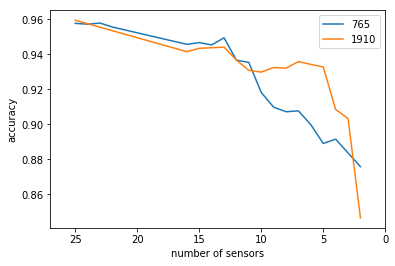

In [29]:
plt.plot(sam[0], sam[1], label='765')
plt.plot(sam2[0], sam2[1], label='1910')
plt.xlim(27, 0)
plt.legend()
plt.xlabel('number of sensors')
plt.ylabel('accuracy')
plt.show()
#sns.lineplot(x=sam[0], y=sam[1], sort=False)

In [21]:
sam[0][0]

25

# Selection with subsets, cost = 1

In [20]:
set1 = [24, 9, 22, 23, 10, 6]
set2 = [24, 9, 22, 23, 27, 26]
set3 = [24, 9, 22, 23]
set4 = [24, 22, 23]

In [21]:
def transform_ys(y, yval, comparison_set):
    mask = np.isin(y, comparison_set, invert=True)
    yhat = y.copy()
    yhat[mask] = 0
    mask_val = np.isin(yval, comparison_set, invert=True)
    yvalhat = yval.copy()
    yvalhat[mask_val] = 0
    return yhat, yvalhat

In [16]:
with open( stats_added_base_path+'train-data-rfecv3.pk', "rb" ) as users_pickle_file:
    data = pickle.load(users_pickle_file)
Xrfe = data['X']
y = data['y']
XValrfe = data['Xval']
yval = data['yval']
gestures = data['gestures']
rfe_features = data['headers']

In [17]:
yhat1, yvalhat1 = transform_ys(y, yval, set1)

In [19]:
results=[]
select_features(0.5, Xrfe, yhat1, XValrfe, yvalhat1, cost_per_sensor, mod_costs, rfe_features.flatten(), normalizer, classifiers, fit_classifier, results)

sensor removed: 6
sensors inclusive removed: [[0.02105263]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03157895]
 [0.02105263]
 [0.01052632]
 [0.02105263]
 [0.03157895]
 [0.02105263]
 [0.08421053]
 [0.03157895]
 [0.03389831]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.15254237]
 [0.18644068]
 [0.01864407]
 [0.02934272]
 [0.04237288]
 [0.05205811]
 [0.02663438]
 [0.01634877]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7592951826705465 for passive agressive (test: 0.7902203324313876)
val score 0.6711930164888458 for sgd[hinge] (test: 0.7756345831722716)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.8661493695441319 for LDA (test: 0.9307563458317227)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.43727772389266084 for QDA (test: 0.33445432289653393)
val score 0.37859683155512447 for nn (test: 0.6747068676716917)
val score 0.5260265114775299 for gaussian navie bayse (test: 0.44398917665249327)
val score 0.9734885224700938 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9730035564177174 for random forrest (test: 0.997577631748486)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9712253475590042 for extra trees (test: 1.0)
val score 0.526188166828322 for ada boost (test: 0.7695271227934545)
Fitting estimator with 191 features.
Fitting estimator with 182 features.
Fitting estimator with 173 features.
Fitting estimator with 164 features.
Fitting estimator with 155 features.
Fitting estimator with 146 features.
Fitting estimator with 137 features.
Fitting estimator with 128 features.
Fitting estimator with 119 features.
Fitting estimator with 110 features.
Fitting estimator with 101 features.
Fitting estimator with 92 features.
Fitting estimator with 83 features.
Fitting estimator with 74 features.
Fitting estimator with 65 features.
Fitting estimator with 56 features.
Fitting estimator with 47 features.
Fitting estimator with 38 features.
Fitting estimator with 29 features.
Fitting estimator with 20 features.
Fitting estimator with 11 features.
Fitting estimator with 2 features.
Fitting estimator with 191 features.
Fitting estimator with 182 features

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7356935014548982 for passive agressive (test: 0.7768071124855045)
val score 0.7022308438409312 for sgd[hinge] (test: 0.8097538976935962)
val score 0.7997090203685742 for LDA (test: 0.9015590774384745)
val score 0.6291626252828969 for QDA (test: 0.3576729802860456)
val score 0.20853540252182348 for nn (test: 0.11649272001030796)
val score 0.48480439702554157 for gaussian navie bayse (test: 0.30952196881845123)
val score 0.9670223084384093 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9658907209828645 for random forrest (test: 0.9967014559979384)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.969447138700291 for extra trees (test: 1.0)
val score 0.7723892660847073 for ada boost (test: 0.8815874243009921)
Fitting estimator with 55 features.
Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting est

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7103136113805367 for passive agressive (test: 0.7669372503543358)
val score 0.7292272874232137 for sgd[hinge] (test: 0.8615771163509857)
val score 0.7972841901066926 for LDA (test: 0.9001030795000644)
val score 0.6374070481732945 for QDA (test: 0.35870377528668984)
val score 0.2096669899773682 for nn (test: 0.11828372632392734)
val score 0.4856126737795021 for gaussian navie bayse (test: 0.3125756990078598)
val score 0.966537342386033 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9670223084384093 for random forrest (test: 0.996868960185543)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9710636922082121 for extra trees (test: 1.0)
val score 0.7723892660847073 for ada boost (test: 0.8815874243009921)
Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting est

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6475913352731976 for passive agressive (test: 0.7475325344672078)
val score 0.6083090850307146 for sgd[hinge] (test: 0.7848988532405617)
val score 0.7583252505657937 for LDA (test: 0.8827341837392089)
val score 0.5127707727125768 for QDA (test: 0.3009019456255637)
val score 0.20126091173617847 for nn (test: 0.10587553150367221)
val score 0.3718073068218558 for gaussian navie bayse (test: 0.25957995103723747)
val score 0.9613643711606854 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9626576139670223 for random forrest (test: 0.9957995103723747)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9637892014225671 for extra trees (test: 1.0)
val score 0.7546071774975751 for ada boost (test: 0.875982476484989)
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting estimator with 5 features.
Fitting estimator with 3 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estima

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5016165535079211 for passive agressive (test: 0.6645019971653138)
val score 0.7138700290979632 for sgd[hinge] (test: 0.8485246746553279)
val score 0.7550921435499516 for LDA (test: 0.8824249452390156)
val score 0.457807953443259 for QDA (test: 0.26258214147661385)
val score 0.19527966375687036 for nn (test: 0.09148305630717692)
val score 0.3548334949886841 for gaussian navie bayse (test: 0.23945367864965855)
val score 0.9582929194956353 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.959262851600388 for random forrest (test: 0.9955160417471975)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9662140316844487 for extra trees (test: 1.0)
val score 0.5643388296152603 for ada boost (test: 0.7881587424300992)
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.486905916585839 for passive agressive (test: 0.6166344543228965)
val score 0.581312641448432 for sgd[hinge] (test: 0.7186445045741529)
val score 0.7544455221467832 for LDA (test: 0.8829661126143539)
val score 0.4741351438732622 for QDA (test: 0.3319675299574797)
val score 0.324118978338183 for nn (test: 0.6245973457028733)
val score 0.35564177174264466 for gaussian navie bayse (test: 0.2653652879783533)
val score 0.9589395408988037 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.960879405108309 for random forrest (test: 0.9959412446849633)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9610410604591012 for extra trees (test: 1.0)
val score 0.7625282896863887 for ada boost (test: 0.8803247004252029)
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimat

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5674102812803103 for passive agressive (test: 0.6998453807499033)
val score 0.5375040413837698 for sgd[hinge] (test: 0.6935833011209895)
val score 0.7568703524086647 for LDA (test: 0.8828501481767813)
val score 0.4649207888781119 for QDA (test: 0.32942919726839326)
val score 0.34949886841254446 for nn (test: 0.6725164282953228)
val score 0.37811186550274817 for gaussian navie bayse (test: 0.2867285143667053)
val score 0.9579696087940511 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9555447785321695 for random forrest (test: 0.9960572091225357)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9644358228257355 for extra trees (test: 1.0)
val score 0.7851600387972842 for ada boost (test: 0.8892797319932998)
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 24 features.
Fitting estimator

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6741028128031038 for passive agressive (test: 0.7599149594124469)
val score 0.5906886517943744 for sgd[hinge] (test: 0.7222265172013914)
val score 0.7581635952150018 for LDA (test: 0.8853240561783275)
val score 0.47575169738118334 for QDA (test: 0.23432547352145341)
val score 0.37487875848690594 for nn (test: 0.6876562298672851)
val score 0.3986420950533463 for gaussian navie bayse (test: 0.20467723231542326)
val score 0.9550598124797931 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9557064338829615 for random forrest (test: 0.9959670145599794)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9639508567733592 for extra trees (test: 1.0)
val score 0.792111218881345 for ada boost (test: 0.897332817935833)
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator w

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6207565470417071 for passive agressive (test: 0.38815874243009924)
val score 0.7284190106692533 for sgd[hinge] (test: 0.8701327148563328)
val score 0.779017135467184 for LDA (test: 0.8975776317484859)
val score 0.5819592628516004 for QDA (test: 0.29380234505862646)
val score 0.2154865826058842 for nn (test: 0.1900012884937508)
val score 0.5905269964435823 for gaussian navie bayse (test: 0.29255250612034533)
val score 0.9354995150339476 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9374393792434529 for random forrest (test: 0.9911480479319675)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9484319430973165 for extra trees (test: 1.0)
val score 0.7010992563853864 for ada boost (test: 0.8482025512176266)
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
sensor removed: 16
sensors inclusive removed: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.0169

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.711930164888458 for passive agressive (test: 0.869668857106043)
val score 0.7583252505657937 for sgd[hinge] (test: 0.8900914830563071)
val score 0.7812803103782735 for LDA (test: 0.899304213374565)
val score 0.7678629162625283 for QDA (test: 0.893918309496199)
val score 0.18606530876171998 for nn (test: 0.09221749774513592)
val score 0.7680245716133205 for gaussian navie bayse (test: 0.8939311944337069)
val score 0.9144843194309732 for decision tree (test: 0.9994330627496457)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.8907209828645328 for random forrest (test: 0.9793583301120989)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9188490139023602 for extra trees (test: 0.9993557531245973)
val score 0.8161978661493695 for ada boost (test: 0.9137739981961087)
done


In [20]:
set1_results1_data_rfecv3_rel = results

In [21]:
with open( stats_added_base_path+'set1-results1-data-rfecv3-rel.pkl', "wb" ) as users_pickle_file:
    pickle.dump(results, users_pickle_file)

In [22]:
with open( stats_added_base_path+'train-data-rfecv3.pk', "rb" ) as users_pickle_file:
    data = pickle.load(users_pickle_file)
Xrfe = data['X']
y = data['y']
XValrfe = data['Xval']
yval = data['yval']
gestures = data['gestures']
rfe_features = data['headers']

In [23]:
yhat2, yvalhat2 = transform_ys(y, yval, set2)

In [24]:
results=[]
select_features(0.5, Xrfe, yhat2, XValrfe, yvalhat2, cost_per_sensor, mod_costs, rfe_features.flatten(), normalizer, classifiers, fit_classifier, results)

sensor removed: 6
sensors inclusive removed: [[0.02105263]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03157895]
 [0.02105263]
 [0.01052632]
 [0.02105263]
 [0.03157895]
 [0.02105263]
 [0.08421053]
 [0.03157895]
 [0.03389831]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.15254237]
 [0.18644068]
 [0.01864407]
 [0.02934272]
 [0.04237288]
 [0.05205811]
 [0.02663438]
 [0.01634877]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7216294859359845 for passive agressive (test: 0.7700038654812524)
val score 0.7183963789201423 for sgd[hinge] (test: 0.8227934544517459)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.8882961526026512 for LDA (test: 0.9394923334621827)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.4864209505334627 for QDA (test: 0.44066486277541556)
val score 0.4004203039120595 for nn (test: 0.6773611647983507)
val score 0.5137407048173295 for gaussian navie bayse (test: 0.5807370184254607)
val score 0.9838344649207889 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9825412221144519 for random forrest (test: 0.9973972426233733)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9825412221144519 for extra trees (test: 1.0)
val score 0.5806660200452635 for ada boost (test: 0.5153330756345832)
Fitting estimator with 191 features.
Fitting estimator with 182 features.
Fitting estimator with 173 features.
Fitting estimator with 164 features.
Fitting estimator with 155 features.
Fitting estimator with 146 features.
Fitting estimator with 137 features.
Fitting estimator with 128 features.
Fitting estimator with 119 features.
Fitting estimator with 110 features.
Fitting estimator with 101 features.
Fitting estimator with 92 features.
Fitting estimator with 83 features.
Fitting estimator with 74 features.
Fitting estimator with 65 features.
Fitting estimator with 56 features.
Fitting estimator with 47 features.
Fitting estimator with 38 features.
Fitting estimator with 29 features.
Fitting estimator with 20 features.
Fitting estimator with 11 features.
Fitting estimator with 2 features.
Fitting estimator with 191 features.
Fitting estimator with 182 feature

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6264144843194309 for passive agressive (test: 0.7389769359618605)
val score 0.6884901390236017 for sgd[hinge] (test: 0.8039943306274966)
val score 0.8267054639508568 for LDA (test: 0.9181806468238629)
val score 0.6369220821209182 for QDA (test: 0.3976807112485504)
val score 0.3957322987390883 for nn (test: 0.6753253446720784)
val score 0.44503718073068216 for gaussian navie bayse (test: 0.30972812781858006)
val score 0.9762366634335596 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9801163918525703 for random forrest (test: 0.9971266589357042)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.983996120271581 for extra trees (test: 1.0)
val score 0.5050113158745555 for ada boost (test: 0.7233088519520681)
Fitting estimator with 71 features.
Fitting estimator with 68 features.
Fitting estimator with 65 features.
Fitting estimator with 62 features.
Fitting estimator with 59 features.
Fitting estimator with 56 features.
Fitting estimator with 53 features.
Fitting estimator with 50 features.
Fitting estimator with 47 features.
Fitting estimator with 44 features.
Fitting estimator with 41 features.
Fitting estimator with 38 features.
Fitting estimator with 35 features.
Fitting estimator with 32 features.
Fitting estimator with 29 features.
Fitting estimator with 26 features.
Fitting estimator with 23 features.
Fitting estimator with 20 features.
Fitting estimator with 17 features.
Fitting estimator with 14 features.
Fitting estimator with 11 features.
Fitting estimator with 8 features.
Fitting estimator with 5 features.
Fitting estimator with 2 features.
Fitting estim

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.755900420303912 for passive agressive (test: 0.8167761886354851)
val score 0.7534755900420305 for sgd[hinge] (test: 0.8356397371472748)
val score 0.8239573229873909 for LDA (test: 0.9161834815101146)
val score 0.6739411574523116 for QDA (test: 0.4372761242107976)
val score 0.08325250565793728 for nn (test: 0.041592578275995364)
val score 0.5106692531522793 for gaussian navie bayse (test: 0.3498260533436413)
val score 0.9772065955383124 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9815712900096993 for random forrest (test: 0.9977193660610746)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9856126737795021 for extra trees (test: 1.0)
val score 0.7158098933074685 for ada boost (test: 0.8472361809045226)
Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting est

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7812803103782735 for passive agressive (test: 0.8480994717175622)
val score 0.8396378920142256 for sgd[hinge] (test: 0.9113516299445947)
val score 0.8216941480763014 for LDA (test: 0.9159515526349696)
val score 0.6912382799870675 for QDA (test: 0.4685865223553665)
val score 0.191884901390236 for nn (test: 0.24919469140574668)
val score 0.5355641771742645 for gaussian navie bayse (test: 0.3938409998711506)
val score 0.973811833171678 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9807630132557388 for random forrest (test: 0.9975518618734699)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9835111542192047 for extra trees (test: 1.0)
val score 0.6218881344972519 for ada boost (test: 0.8106043035691277)
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting estimator with 5 features.
Fitting estimator with 3 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estim

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7389266084707405 for passive agressive (test: 0.8228836490143023)
val score 0.7654380860006467 for sgd[hinge] (test: 0.8703002190439376)
val score 0.7725509214354995 for LDA (test: 0.8940858136838037)
val score 0.590042030391206 for QDA (test: 0.44563844865352403)
val score 0.1726479146459748 for nn (test: 0.23920886483700554)
val score 0.41545425153572585 for gaussian navie bayse (test: 0.3552248421595155)
val score 0.9705787261558357 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9746201099256385 for random forrest (test: 0.9965726066228578)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9806013579049466 for extra trees (test: 1.0)
val score 0.5635305528612997 for ada boost (test: 0.7748614869217885)
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6956029744584545 for passive agressive (test: 0.761899239788687)
val score 0.6283543485289363 for sgd[hinge] (test: 0.7596314907872695)
val score 0.7413514387326221 for LDA (test: 0.8788429326117767)
val score 0.5168121564823795 for QDA (test: 0.39052957093158097)
val score 0.09844810863239573 for nn (test: 0.19511660868444788)
val score 0.34303265438086 for gaussian navie bayse (test: 0.30646823862904266)
val score 0.9700937601034594 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9763983187843518 for random forrest (test: 0.9973328179358331)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9822179114128677 for extra trees (test: 1.0)
val score 0.4862592951826705 for ada boost (test: 0.7462182708413864)
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimat

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6270611057225994 for passive agressive (test: 0.7424172142765106)
val score 0.7301972195279663 for sgd[hinge] (test: 0.8528540136580337)
val score 0.732460394439056 for LDA (test: 0.8757505476098442)
val score 0.5006466214031684 for QDA (test: 0.3734054889833784)
val score 0.28435176204332363 for nn (test: 0.6224842159515527)
val score 0.3448108632395732 for gaussian navie bayse (test: 0.31217626594511017)
val score 0.9702554154542515 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9786614936954413 for random forrest (test: 0.9970235794356397)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9814096346589072 for extra trees (test: 1.0)
val score 0.5231167151632719 for ada boost (test: 0.7463986599664992)
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 24 features.
Fitting estimator

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.4673456191399935 for passive agressive (test: 0.46567452647854657)
val score 0.5478499838344649 for sgd[hinge] (test: 0.7824764849890478)
val score 0.6954413191076625 for LDA (test: 0.8626852209766782)
val score 0.5019398642095053 for QDA (test: 0.39195979899497485)
val score 0.24814096346589073 for nn (test: 0.395387192372117)
val score 0.40559327513740706 for gaussian navie bayse (test: 0.358020873598763)
val score 0.9589395408988037 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9666989977368251 for random forrest (test: 0.9959025898724391)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9707403815066279 for extra trees (test: 1.0)
val score 0.39961202715809896 for ada boost (test: 0.5850019327406262)
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 feature

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.4479469770449402 for passive agressive (test: 0.6326762015204226)
val score 0.6666666666666666 for sgd[hinge] (test: 0.8349568354593481)
val score 0.7009376010345942 for LDA (test: 0.8601340033500837)
val score 0.49127061105722597 for QDA (test: 0.3884422110552763)
val score 0.2161332040090527 for nn (test: 0.358742430099214)
val score 0.4068865179437439 for gaussian navie bayse (test: 0.35164282953227677)
val score 0.9571613320400906 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9642741674749434 for random forrest (test: 0.9949619894343512)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9704170708050437 for extra trees (test: 1.0)
val score 0.34788231490462335 for ada boost (test: 0.6222780569514238)
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 feature

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.3368897510507598 for passive agressive (test: 0.6234248163896405)
val score 0.7085354025218235 for sgd[hinge] (test: 0.8584976162865611)
val score 0.7146783058519238 for LDA (test: 0.8644891122278057)
val score 0.476721629485936 for QDA (test: 0.36843190310526996)
val score 0.16117038473973488 for nn (test: 0.23646437314779023)
val score 0.40122858066601996 for gaussian navie bayse (test: 0.33807499033629684)
val score 0.9552214678305851 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9555447785321695 for random forrest (test: 0.9928746295580466)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9681538958939541 for extra trees (test: 1.0)
val score 0.3504688005172971 for ada boost (test: 0.6741270454838294)
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.24474620109925638 for passive agressive (test: 0.601468882875918)
val score 0.7070805043646945 for sgd[hinge] (test: 0.856539105785337)
val score 0.7392499191723246 for LDA (test: 0.8775544388609715)
val score 0.558034270934368 for QDA (test: 0.28835201649272)
val score 0.19107662463627545 for nn (test: 0.10617188506635743)
val score 0.4828645328160362 for gaussian navie bayse (test: 0.2516814843448009)
val score 0.9371160685418687 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9393792434529583 for random forrest (test: 0.986908903491818)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9615260265114776 for extra trees (test: 1.0)
val score 0.5504364694471388 for ada boost (test: 0.7591676330369798)
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
sensor removed: 16
sensors inclusive removed: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.05084746]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


ValueError: Found array with 0 feature(s) (shape=(77610, 0)) while a minimum of 1 is required.

In [25]:
set2_results1_data_rfecv3_rel = results

In [26]:
with open( stats_added_base_path+'set2-results1-data-rfecv3-rel.pkl', "wb" ) as users_pickle_file:
    pickle.dump(results, users_pickle_file)

In [27]:
with open( stats_added_base_path+'train-data-rfecv3.pk', "rb" ) as users_pickle_file:
    data = pickle.load(users_pickle_file)
Xrfe = data['X']
y = data['y']
XValrfe = data['Xval']
yval = data['yval']
gestures = data['gestures']
rfe_features = data['headers']

In [28]:
yhat3, yvalhat3 = transform_ys(y, yval, set3)

In [29]:
results=[]
select_features(0.5, Xrfe, yhat3, XValrfe, yvalhat3, cost_per_sensor, mod_costs, rfe_features.flatten(), normalizer, classifiers, fit_classifier, results)

sensor removed: 6
sensors inclusive removed: [[0.02105263]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03157895]
 [0.02105263]
 [0.01052632]
 [0.02105263]
 [0.03157895]
 [0.02105263]
 [0.08421053]
 [0.03157895]
 [0.03389831]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.15254237]
 [0.18644068]
 [0.01864407]
 [0.02934272]
 [0.04237288]
 [0.05205811]
 [0.02663438]
 [0.01634877]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8364047849983834 for passive agressive (test: 0.8281922432676202)
val score 0.7452311671516327 for sgd[hinge] (test: 0.8404200489627626)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.902521823472357 for LDA (test: 0.9485117897178199)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.43145813126414484 for QDA (test: 0.4295065068934416)
val score 0.4801163918525703 for nn (test: 0.730846540394279)
val score 0.600226317491109 for gaussian navie bayse (test: 0.601468882875918)
val score 0.9860976398318785 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.984157775622373 for random forrest (test: 0.9980930292488082)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.984157775622373 for extra trees (test: 1.0)
val score 0.5530229550598125 for ada boost (test: 0.7765622986728514)
Fitting estimator with 191 features.
Fitting estimator with 182 features.
Fitting estimator with 173 features.
Fitting estimator with 164 features.
Fitting estimator with 155 features.
Fitting estimator with 146 features.
Fitting estimator with 137 features.
Fitting estimator with 128 features.
Fitting estimator with 119 features.
Fitting estimator with 110 features.
Fitting estimator with 101 features.
Fitting estimator with 92 features.
Fitting estimator with 83 features.
Fitting estimator with 74 features.
Fitting estimator with 65 features.
Fitting estimator with 56 features.
Fitting estimator with 47 features.
Fitting estimator with 38 features.
Fitting estimator with 29 features.
Fitting estimator with 20 features.
Fitting estimator with 11 features.
Fitting estimator with 2 features.
Fitting estimator with 191 features.
Fitting estimator with 182 features

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7062722276107339 for passive agressive (test: 0.770648112356655)
val score 0.7310054962819268 for sgd[hinge] (test: 0.8270068290168793)
val score 0.8325250565793728 for LDA (test: 0.919430485762144)
val score 0.6571290009699321 for QDA (test: 0.4500450972812781)
val score 0.33236340122858066 for nn (test: 0.609715242881072)
val score 0.5598124797930811 for gaussian navie bayse (test: 0.4073959541296225)
val score 0.9768832848367281 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9823795667636599 for random forrest (test: 0.9976034016235021)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9838344649207889 for extra trees (test: 1.0)
val score 0.6865502748140964 for ada boost (test: 0.8307692307692308)
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8022955059812481 for passive agressive (test: 0.8515655199072284)
val score 0.7825735531846104 for sgd[hinge] (test: 0.8758536271099086)
val score 0.832848367280957 for LDA (test: 0.919159902074475)
val score 0.6661817006142904 for QDA (test: 0.45479963922174976)
val score 0.2376333656644035 for nn (test: 0.2711635098569772)
val score 0.5648237956676366 for gaussian navie bayse (test: 0.41666022419791265)
val score 0.9778532169414808 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9804397025541546 for random forrest (test: 0.9973585878108491)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9831878435176205 for extra trees (test: 1.0)
val score 0.7537989007436147 for ada boost (test: 0.8588841644118026)
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7803103782735209 for passive agressive (test: 0.8515784048447365)
val score 0.8045586808923375 for sgd[hinge] (test: 0.8855431001159645)
val score 0.8320400905269965 for LDA (test: 0.9186187346991367)
val score 0.6669899773682509 for QDA (test: 0.45447751578404844)
val score 0.23116715163271903 for nn (test: 0.26679551604174717)
val score 0.574199806013579 for gaussian navie bayse (test: 0.41855431001159643)
val score 0.975266731328807 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9807630132557388 for random forrest (test: 0.9975132070609457)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9830261881668283 for extra trees (test: 1.0)
val score 0.7248625929518268 for ada boost (test: 0.8498775930936735)
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7943743937924346 for passive agressive (test: 0.83348795258343)
val score 0.8039120594891691 for sgd[hinge] (test: 0.8945367864965855)
val score 0.8181377303588748 for LDA (test: 0.9143022806339389)
val score 0.6417717426446815 for QDA (test: 0.4433062749645664)
val score 0.10556094406724863 for nn (test: 0.2044453034402783)
val score 0.5428386679599094 for gaussian navie bayse (test: 0.40258987243911865)
val score 0.9775299062398966 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9807630132557388 for random forrest (test: 0.9978482154361551)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9836728095699968 for extra trees (test: 1.0)
val score 0.7783705140640155 for ada boost (test: 0.873315294420822)
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estima

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7466860653087617 for passive agressive (test: 0.8152428810720268)
val score 0.7322987390882637 for sgd[hinge] (test: 0.8379719108362325)
val score 0.783381829938571 for LDA (test: 0.8971524288107202)
val score 0.5321694148076301 for QDA (test: 0.38966628011854143)
val score 0.08664726802457161 for nn (test: 0.18426749130266717)
val score 0.4508567733591982 for gaussian navie bayse (test: 0.3495941244684963)
val score 0.9763983187843518 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9780148722922729 for random forrest (test: 0.9972941631233089)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9823795667636599 for extra trees (test: 1.0)
val score 0.6935014548981572 for ada boost (test: 0.8300347893312717)
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7153249272550921 for passive agressive (test: 0.7258085298286303)
val score 0.6925315227934045 for sgd[hinge] (test: 0.8278958897049348)
val score 0.7824118978338183 for LDA (test: 0.8967787656229868)
val score 0.5360491432266408 for QDA (test: 0.36628011854142506)
val score 0.4165858389912706 for nn (test: 0.7182321865738951)
val score 0.45473650177820885 for gaussian navie bayse (test: 0.3518876433449298)
val score 0.9741351438732622 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9770449401875202 for random forrest (test: 0.9970751191856719)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9835111542192047 for extra trees (test: 1.0)
val score 0.715001616553508 for ada boost (test: 0.8411673753382296)
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6983511154219205 for passive agressive (test: 0.7989820899368638)
val score 0.677335919818946 for sgd[hinge] (test: 0.8343898982089937)
val score 0.764468153895894 for LDA (test: 0.889034918180647)
val score 0.5161655350792111 for QDA (test: 0.3773353949233347)
val score 0.2559004203039121 for nn (test: 0.501932740626208)
val score 0.46023278370514065 for gaussian navie bayse (test: 0.3539621182837263)
val score 0.9657290656320724 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9692854833494988 for random forrest (test: 0.9955933513722458)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9765599741351438 for extra trees (test: 1.0)
val score 0.648237956676366 for ada boost (test: 0.798788815874243)
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.42127384416424185 for passive agressive (test: 0.6667182064166989)
val score 0.8470740381506627 for sgd[hinge] (test: 0.9223682515139802)
val score 0.7858066602004526 for LDA (test: 0.9015461925009663)
val score 0.5363724539282251 for QDA (test: 0.26317484860198426)
val score 0.32460394439055934 for nn (test: 0.1806983636129365)
val score 0.49951503394762364 for gaussian navie bayse (test: 0.2436412833397758)
val score 0.9600711283543485 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9660523763336566 for random forrest (test: 0.9946012111841258)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9757516973811833 for extra trees (test: 1.0)
val score 0.5756547041707081 for ada boost (test: 0.7664089679165056)
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.2883931458131264 for passive agressive (test: 0.6402267749001417)
val score 0.40817976075008083 for sgd[hinge] (test: 0.7169565777605978)
val score 0.8461041060459101 for LDA (test: 0.927174333204484)
val score 0.8105399288716456 for QDA (test: 0.9118026027573767)
val score 0.47801487229227285 for nn (test: 0.7497487437185929)
val score 0.8087617200129325 for gaussian navie bayse (test: 0.9119185671949491)
val score 0.9515033947623667 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.953443258971872 for random forrest (test: 0.9882875918051798)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9700937601034594 for extra trees (test: 1.0)
val score 0.8782735208535403 for ada boost (test: 0.9405875531503674)
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
sensor removed: 17
sensors inclusive removed: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03389831]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


ValueError: Found array with 0 feature(s) (shape=(77610, 0)) while a minimum of 1 is required.

In [30]:
set3_results1_data_rfecv3_rel = results

In [31]:
with open( stats_added_base_path+'set3-results1-data-rfecv3-rel.pkl', "wb" ) as users_pickle_file:
    pickle.dump(results, users_pickle_file)

In [32]:
with open( stats_added_base_path+'train-data-rfecv3.pk', "rb" ) as users_pickle_file:
    data = pickle.load(users_pickle_file)
Xrfe = data['X']
y = data['y']
XValrfe = data['Xval']
yval = data['yval']
gestures = data['gestures']
rfe_features = data['headers']

In [33]:
yhat4, yvalhat4 = transform_ys(y, yval, set4)

In [34]:
results=[]
select_features(0.5, Xrfe, yhat4, XValrfe, yvalhat4, cost_per_sensor, mod_costs, rfe_features.flatten(), normalizer, classifiers, fit_classifier, results)

sensor removed: 6
sensors inclusive removed: [[0.02105263]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03157895]
 [0.02105263]
 [0.01052632]
 [0.02105263]
 [0.03157895]
 [0.02105263]
 [0.08421053]
 [0.03157895]
 [0.03389831]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.15254237]
 [0.18644068]
 [0.01864407]
 [0.02934272]
 [0.04237288]
 [0.05205811]
 [0.02663438]
 [0.01634877]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.725185903653411 for passive agressive (test: 0.768187089292617)
val score 0.7683478823149046 for sgd[hinge] (test: 0.8534982605334362)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.9118978338182994 for LDA (test: 0.9546707898466692)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.6936631102489492 for QDA (test: 0.5759051668599408)
val score 0.6325573876495312 for nn (test: 0.8006055920628785)
val score 0.7434529582929194 for gaussian navie bayse (test: 0.6720525705450329)
val score 0.9864209505334627 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9846427416747494 for random forrest (test: 0.998286303311429)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9856126737795021 for extra trees (test: 1.0)
val score 0.9096346589072098 for ada boost (test: 0.9474165700296353)
Fitting estimator with 191 features.
Fitting estimator with 182 features.
Fitting estimator with 173 features.
Fitting estimator with 164 features.
Fitting estimator with 155 features.
Fitting estimator with 146 features.
Fitting estimator with 137 features.
Fitting estimator with 128 features.
Fitting estimator with 119 features.
Fitting estimator with 110 features.
Fitting estimator with 101 features.
Fitting estimator with 92 features.
Fitting estimator with 83 features.
Fitting estimator with 74 features.
Fitting estimator with 65 features.
Fitting estimator with 56 features.
Fitting estimator with 47 features.
Fitting estimator with 38 features.
Fitting estimator with 29 features.
Fitting estimator with 20 features.
Fitting estimator with 11 features.
Fitting estimator with 2 features.
Fitting estimator with 191 features.
Fitting estimator with 182 feature

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6812156482379567 for passive agressive (test: 0.745625563716016)
val score 0.8558034270934368 for sgd[hinge] (test: 0.9219301636387064)
val score 0.8785968315551244 for LDA (test: 0.9418245071511403)
val score 0.7909796314258002 for QDA (test: 0.5268006700167505)
val score 0.13449725185903652 for nn (test: 0.14312588583945368)
val score 0.7405431619786615 for gaussian navie bayse (test: 0.5105785336941115)
val score 0.9848043970255416 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.983996120271581 for random forrest (test: 0.9980801443113001)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9877141933397996 for extra trees (test: 1.0)
val score 0.9261235046880052 for ada boost (test: 0.9567323798479578)
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8785968315551244 for passive agressive (test: 0.8907099600566938)
val score 0.8674426123504687 for sgd[hinge] (test: 0.9239659837649787)
val score 0.8773035887487876 for LDA (test: 0.9409869862131168)
val score 0.7895247332686712 for QDA (test: 0.5238500193274063)
val score 0.1327190430003233 for nn (test: 0.14161834815101146)
val score 0.739896540575493 for gaussian navie bayse (test: 0.5081690503801056)
val score 0.9836728095699968 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.984157775622373 for random forrest (test: 0.9980286045612679)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.986905916585839 for extra trees (test: 1.0)
val score 0.9211121888134497 for ada boost (test: 0.9551990722844994)
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7025541545425154 for passive agressive (test: 0.7834170854271357)
val score 0.8659877141933399 for sgd[hinge] (test: 0.9188377786367736)
val score 0.8752020691884901 for LDA (test: 0.9405746682128592)
val score 0.7913029421273843 for QDA (test: 0.5273933771421209)
val score 0.13449725185903652 for nn (test: 0.15510887772194304)
val score 0.7415130940834141 for gaussian navie bayse (test: 0.5022548640639093)
val score 0.9844810863239574 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.98545101842871 for random forrest (test: 0.9981961087488725)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.986905916585839 for extra trees (test: 1.0)
val score 0.9232137083737472 for ada boost (test: 0.9571575827857235)
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8417394115745231 for passive agressive (test: 0.8903234119314521)
val score 0.8247655997413514 for sgd[hinge] (test: 0.864334492977709)
val score 0.8771419333979955 for LDA (test: 0.9399561912124726)
val score 0.7849983834464921 for QDA (test: 0.5251900528282438)
val score 0.2824118978338183 for nn (test: 0.2944594768715372)
val score 0.736986744261235 for gaussian navie bayse (test: 0.49833784306146117)
val score 0.9836728095699968 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9856126737795021 for random forrest (test: 0.9981445689988404)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.98545101842871 for extra trees (test: 1.0)
val score 0.9057549304881991 for ada boost (test: 0.9474552248421595)
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estim

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7308438409311349 for passive agressive (test: 0.7845509599278445)
val score 0.7366634335596508 for sgd[hinge] (test: 0.8204870506378042)
val score 0.8524086647268024 for LDA (test: 0.9291457286432161)
val score 0.7552537989007435 for QDA (test: 0.5088261821930163)
val score 0.2478176527643065 for nn (test: 0.27345702873341066)
val score 0.7161332040090527 for gaussian navie bayse (test: 0.4868444788042778)
val score 0.9812479793081151 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9807630132557388 for random forrest (test: 0.9976291714985183)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9852893630779179 for extra trees (test: 1.0)
val score 0.9144843194309732 for ada boost (test: 0.9547480994717176)
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8516003879728419 for passive agressive (test: 0.849748743718593)
val score 0.7203362431296476 for sgd[hinge] (test: 0.8003865481252417)
val score 0.8549951503394764 for LDA (test: 0.929854400206159)
val score 0.7555771096023278 for QDA (test: 0.5059399561912125)
val score 0.2539605560944067 for nn (test: 0.2584460765365288)
val score 0.7133850630455868 for gaussian navie bayse (test: 0.4764076794227548)
val score 0.9820562560620757 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9833494988684125 for random forrest (test: 0.9979255250612035)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9852893630779179 for extra trees (test: 1.0)
val score 0.9217588102166182 for ada boost (test: 0.9586135807241335)
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7925961849337214 for passive agressive (test: 0.8261821930163639)
val score 0.747171031361138 for sgd[hinge] (test: 0.7109908516943692)
val score 0.8564500484966052 for LDA (test: 0.9294549671434094)
val score 0.7518590365341091 for QDA (test: 0.47955160417471976)
val score 0.6024894924021985 for nn (test: 0.8021131297513205)
val score 0.7143549951503396 for gaussian navie bayse (test: 0.47298028604561265)
val score 0.9836728095699968 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9830261881668283 for random forrest (test: 0.9977322509985826)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9846427416747494 for extra trees (test: 1.0)
val score 0.9199806013579049 for ada boost (test: 0.9569256539105785)
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6944713870029098 for passive agressive (test: 0.5324571575827858)
val score 0.8651794374393792 for sgd[hinge] (test: 0.9307821157067389)
val score 0.8485289363077918 for LDA (test: 0.9274578018296611)
val score 0.709182023924992 for QDA (test: 0.47075119185671943)
val score 0.5333010022631749 for nn (test: 0.4769875016106172)
val score 0.6912382799870675 for gaussian navie bayse (test: 0.4595670660997294)
val score 0.9754283866795991 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9776915615906887 for random forrest (test: 0.996598376497874)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9801163918525703 for extra trees (test: 1.0)
val score 0.8912059489169092 for ada boost (test: 0.9465017394665636)
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8902360168121565 for passive agressive (test: 0.9464373147790234)
val score 0.8469123827998707 for sgd[hinge] (test: 0.9268006700167504)
val score 0.8727772389266085 for LDA (test: 0.9412704548382941)
val score 0.7179114128677659 for QDA (test: 0.34785465790490916)
val score 0.593113482056256 for nn (test: 0.28546579049091614)
val score 0.7017458777885548 for gaussian navie bayse (test: 0.3336683417085427)
val score 0.9697704494018752 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9747817652764307 for random forrest (test: 0.9960700940600438)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.978499838344649 for extra trees (test: 1.0)
val score 0.8913676042677013 for ada boost (test: 0.946102306403814)
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
sensor removed: 17
sensors inclusive removed: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.      

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8829615260265115 for passive agressive (test: 0.5263754670789846)
val score 0.9081797607500808 for sgd[hinge] (test: 0.9558046643473779)
val score 0.9081797607500808 for LDA (test: 0.9558046643473779)
val score 0.7264791464597478 for QDA (test: 0.3631619636644763)
val score 0.6222114451988361 for nn (test: 0.2906841901816776)
val score 0.7044940187520207 for gaussian navie bayse (test: 0.34547094446591936)
val score 0.9717103136113805 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9642741674749434 for random forrest (test: 0.9926684705579178)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9783381829938571 for extra trees (test: 1.0)
val score 0.9081797607500808 for ada boost (test: 0.9558175492848859)
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
sensor removed: 16
sensors inclusive removed: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03389831]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


ValueError: Found array with 0 feature(s) (shape=(77610, 0)) while a minimum of 1 is required.

In [35]:
set4_results1_data_rfecv3_rel = results

In [36]:
with open( stats_added_base_path+'set4-results1-data-rfecv3-rel.pkl', "wb" ) as users_pickle_file:
    pickle.dump(results, users_pickle_file)

In [28]:
def compute_all_selections(basedataset, basesetshort, sets):
    i = 0
    for s in sets:
        #if pathlib.Path(stats_added_base_path+f'set{i}-results1-data-{basesetshort}-rel.pkl').exists():
        #    print("===== SKIPPING!!!!!! ===== File already exists: ", stats_added_base_path+f'set{i}-results1-data-{basesetshort}-rel.pkl')
        #    i += 1
        #    continue
        with open( stats_added_base_path+basedataset, "rb" ) as users_pickle_file:
            data = pickle.load(users_pickle_file)
        Xrfe = data['X']
        y = data['y']
        XValrfe = data['Xval']
        yval = data['yval']
        gestures = data['gestures']
        rfe_features = data['headers']
        yhat, yvalhat = transform_ys(y, yval, s)
        try:
            results=[]
            select_features(0.5, Xrfe, yhat, XValrfe, yvalhat, cost_per_sensor, mod_costs, rfe_features.flatten(), normalizer, classifiers, fit_classifier, results)
        except Exception as e:
            print(e)
        with open( stats_added_base_path+f'set{i}-results1-data-{basesetshort}-rel.pkl', "wb" ) as users_pickle_file:
            pickle.dump(results, users_pickle_file)
        i += 1

In [23]:
sets = [set1, set2, set3, set4]

In [29]:
# redo that set, saving did not work, and then here we also beginn with 0 at least:
compute_all_selections('train-data-rfecv3.pk', 'rfecv3', sets)

sensor removed: 6
sensors inclusive removed: [[0.02105263]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03157895]
 [0.02105263]
 [0.01052632]
 [0.02105263]
 [0.03157895]
 [0.02105263]
 [0.08421053]
 [0.03157895]
 [0.03389831]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.15254237]
 [0.18644068]
 [0.01864407]
 [0.02934272]
 [0.04237288]
 [0.05205811]
 [0.02663438]
 [0.01634877]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.811024894924022 for passive agressive (test: 0.8432160804020101)
val score 0.5535079211121888 for sgd[hinge] (test: 0.7326890864579307)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.8661493695441319 for LDA (test: 0.9307563458317227)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.43727772389266084 for QDA (test: 0.33445432289653393)
val score 0.37859683155512447 for nn (test: 0.6747068676716917)
val score 0.5260265114775299 for gaussian navie bayse (test: 0.44398917665249327)
val score 0.9726802457161332 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9688005172971226 for random forrest (test: 0.9977193660610746)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9704170708050437 for extra trees (test: 1.0)
val score 0.526188166828322 for ada boost (test: 0.7695271227934545)

Fitting estimator with 191 features.
Fitting estimator with 182 features.
Fitting estimator with 173 features.
Fitting estimator with 164 features.
Fitting estimator with 155 features.
Fitting estimator with 146 features.
Fitting estimator with 137 features.
Fitting estimator with 128 features.
Fitting estimator with 119 features.
Fitting estimator with 110 features.
Fitting estimator with 101 features.
Fitting estimator with 92 features.
Fitting estimator with 83 features.
Fitting estimator with 74 features.
Fitting estimator with 65 features.
Fitting estimator with 56 features.
Fitting estimator with 47 features.
Fitting estimator with 38 features.
Fitting estimator with 29 features.
Fitting estimator with 20 features.
Fitting estimator with 11 features.
Fitting estimator with 2 features.
Fitting estimator with 191 features.
Fitting estimator with 182 feature

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6542192046556741 for passive agressive (test: 0.7407292874629559)
val score 0.5871322340769479 for sgd[hinge] (test: 0.7620796289137998)
val score 0.7997090203685742 for LDA (test: 0.9015590774384745)
val score 0.6291626252828969 for QDA (test: 0.3576729802860456)
val score 0.20853540252182348 for nn (test: 0.11649272001030796)
val score 0.48480439702554157 for gaussian navie bayse (test: 0.30952196881845123)
val score 0.9688005172971226 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9681538958939541 for random forrest (test: 0.9969720396856075)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9696087940510831 for extra trees (test: 1.0)
val score 0.7723892660847073 for ada boost (test: 0.8815874243009921)

Fitting estimator with 55 features.
Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7247009376010346 for passive agressive (test: 0.7649529699780956)
val score 0.6726479146459747 for sgd[hinge] (test: 0.8034402783146501)
val score 0.7972841901066926 for LDA (test: 0.9001030795000644)
val score 0.6374070481732945 for QDA (test: 0.35870377528668984)
val score 0.2096669899773682 for nn (test: 0.11828372632392734)
val score 0.4856126737795021 for gaussian navie bayse (test: 0.3125756990078598)
val score 0.9673456191399935 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9655674102812803 for random forrest (test: 0.996868960185543)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9721952796637569 for extra trees (test: 1.0)
val score 0.7723892660847073 for ada boost (test: 0.8815874243009921)

Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5693501454898157 for passive agressive (test: 0.7108362324442726)
val score 0.5599741351438733 for sgd[hinge] (test: 0.7664862775415541)
val score 0.7583252505657937 for LDA (test: 0.8827341837392089)
val score 0.5127707727125768 for QDA (test: 0.3009019456255637)
val score 0.20126091173617847 for nn (test: 0.10587553150367221)
val score 0.3718073068218558 for gaussian navie bayse (test: 0.25957995103723747)
val score 0.9605560944067248 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.959262851600388 for random forrest (test: 0.9959670145599794)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9631425800193987 for extra trees (test: 1.0)
val score 0.7546071774975751 for ada boost (test: 0.875982476484989)

Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting estimator with 5 features.
Fitting estimator with 3 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estim

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5987714193339799 for passive agressive (test: 0.7200876175750547)
val score 0.5549628192693178 for sgd[hinge] (test: 0.7666537817291588)
val score 0.7550921435499516 for LDA (test: 0.8824249452390156)
val score 0.457807953443259 for QDA (test: 0.26258214147661385)
val score 0.19527966375687036 for nn (test: 0.09148305630717692)
val score 0.3548334949886841 for gaussian navie bayse (test: 0.23945367864965855)
val score 0.957807953443259 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9602327837051406 for random forrest (test: 0.9957222007473264)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9655674102812803 for extra trees (test: 1.0)
val score 0.5643388296152603 for ada boost (test: 0.7881716273676073)

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.4867442612350469 for passive agressive (test: 0.5961474036850921)
val score 0.61639185257032 for sgd[hinge] (test: 0.7462955804664347)
val score 0.7544455221467832 for LDA (test: 0.8829661126143539)
val score 0.4741351438732622 for QDA (test: 0.3319675299574797)
val score 0.324118978338183 for nn (test: 0.6245973457028733)
val score 0.35564177174264466 for gaussian navie bayse (test: 0.2653652879783533)
val score 0.9569996766892984 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9599094730035564 for random forrest (test: 0.9959798994974874)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.965082444228904 for extra trees (test: 1.0)
val score 0.7625282896863887 for ada boost (test: 0.8803247004252029)

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimat

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.290656320724216 for passive agressive (test: 0.3952969978095606)
val score 0.6011962495958616 for sgd[hinge] (test: 0.7276768457672981)
val score 0.7568703524086647 for LDA (test: 0.8828501481767813)
val score 0.4649207888781119 for QDA (test: 0.32942919726839326)
val score 0.34949886841254446 for nn (test: 0.6725164282953228)
val score 0.37811186550274817 for gaussian navie bayse (test: 0.2867285143667053)
val score 0.9568380213385063 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9595861623019722 for random forrest (test: 0.9960443241850278)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9637892014225671 for extra trees (test: 1.0)
val score 0.7851600387972842 for ada boost (test: 0.8892797319932998)

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 24 features.
Fitting estimato

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.350307145166505 for passive agressive (test: 0.5822445561139028)
val score 0.5289363077917879 for sgd[hinge] (test: 0.712369540007731)
val score 0.7581635952150018 for LDA (test: 0.8853240561783275)
val score 0.47575169738118334 for QDA (test: 0.23432547352145341)
val score 0.37487875848690594 for nn (test: 0.6876562298672851)
val score 0.3986420950533463 for gaussian navie bayse (test: 0.20467723231542326)
val score 0.9542515357258325 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9569996766892984 for random forrest (test: 0.995863935059915)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9628192693178145 for extra trees (test: 1.0)
val score 0.792111218881345 for ada boost (test: 0.897332817935833)

Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.20126091173617847 for passive agressive (test: 0.09158613580724134)
val score 0.623504688005173 for sgd[hinge] (test: 0.8256023708285015)
val score 0.779017135467184 for LDA (test: 0.8975776317484859)
val score 0.5819592628516004 for QDA (test: 0.29380234505862646)
val score 0.2154865826058842 for nn (test: 0.1900012884937508)
val score 0.5905269964435823 for gaussian navie bayse (test: 0.29255250612034533)
val score 0.9364694471387003 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9358228257355319 for random forrest (test: 0.9909161190568225)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9502101519560296 for extra trees (test: 1.0)
val score 0.7010992563853864 for ada boost (test: 0.8482025512176266)

Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
sensor removed: 16
sensors inclusive removed: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.016

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.03766569673456192 for passive agressive (test: 0.018721814199201135)
val score 0.6941480763013256 for sgd[hinge] (test: 0.8623630975389769)
val score 0.7812803103782735 for LDA (test: 0.899304213374565)
val score 0.7678629162625283 for QDA (test: 0.893918309496199)
val score 0.18606530876171998 for nn (test: 0.09221749774513592)
val score 0.7680245716133205 for gaussian navie bayse (test: 0.8939311944337069)
val score 0.9144843194309732 for decision tree (test: 0.9994330627496457)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.8928225024248303 for random forrest (test: 0.9787656229867285)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9196572906563207 for extra trees (test: 0.999252673624533)
val score 0.8161978661493695 for ada boost (test: 0.9137739981961087)

done
sensor removed: 6
sensors inclusive removed: [[0.02105263]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03157895]
 [0.02105263]
 [0.01052632]
 [0.02105263]
 [0.03157895]
 [0.02105263]
 [0.08421053]
 [0.03157895]
 [0.03389831]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.15254237]
 [0.18644068]
 [0.01864407]
 [0.02934272]
 [0.04237288]
 [0.05205811]
 [0.02663438]
 [0.01634877]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7777238926608471 for passive agressive (test: 0.8081303955675815)
val score 0.6818622696411252 for sgd[hinge] (test: 0.8044968431903106)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.8882961526026512 for LDA (test: 0.9394923334621827)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.4864209505334627 for QDA (test: 0.44066486277541556)
val score 0.4004203039120595 for nn (test: 0.6773611647983507)
val score 0.5137407048173295 for gaussian navie bayse (test: 0.5807370184254607)
val score 0.9825412221144519 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9831878435176205 for random forrest (test: 0.9981316840613323)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9831878435176205 for extra trees (test: 1.0)
val score 0.5806660200452635 for ada boost (test: 0.5153330756345832)

Fitting estimator with 191 features.
Fitting estimator with 182 features.
Fitting estimator with 173 features.
Fitting estimator with 164 features.
Fitting estimator with 155 features.
Fitting estimator with 146 features.
Fitting estimator with 137 features.
Fitting estimator with 128 features.
Fitting estimator with 119 features.
Fitting estimator with 110 features.
Fitting estimator with 101 features.
Fitting estimator with 92 features.
Fitting estimator with 83 features.
Fitting estimator with 74 features.
Fitting estimator with 65 features.
Fitting estimator with 56 features.
Fitting estimator with 47 features.
Fitting estimator with 38 features.
Fitting estimator with 29 features.
Fitting estimator with 20 features.
Fitting estimator with 11 features.
Fitting estimator with 2 features.
Fitting estimator with 191 features.
Fitting estimator with 182 featur

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7882314904623342 for passive agressive (test: 0.7995747970622342)
val score 0.4597478176527643 for sgd[hinge] (test: 0.6841257569900786)
val score 0.8267054639508568 for LDA (test: 0.9181806468238629)
val score 0.6369220821209182 for QDA (test: 0.3976807112485504)
val score 0.3957322987390883 for nn (test: 0.6753253446720784)
val score 0.44503718073068216 for gaussian navie bayse (test: 0.30972812781858006)
val score 0.9759133527319754 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9783381829938571 for random forrest (test: 0.9973328179358331)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9838344649207889 for extra trees (test: 1.0)
val score 0.5050113158745555 for ada boost (test: 0.7233088519520681)

Fitting estimator with 71 features.
Fitting estimator with 68 features.
Fitting estimator with 65 features.
Fitting estimator with 62 features.
Fitting estimator with 59 features.
Fitting estimator with 56 features.
Fitting estimator with 53 features.
Fitting estimator with 50 features.
Fitting estimator with 47 features.
Fitting estimator with 44 features.
Fitting estimator with 41 features.
Fitting estimator with 38 features.
Fitting estimator with 35 features.
Fitting estimator with 32 features.
Fitting estimator with 29 features.
Fitting estimator with 26 features.
Fitting estimator with 23 features.
Fitting estimator with 20 features.
Fitting estimator with 17 features.
Fitting estimator with 14 features.
Fitting estimator with 11 features.
Fitting estimator with 8 features.
Fitting estimator with 5 features.
Fitting estimator with 2 features.
Fitting est

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7450695118008406 for passive agressive (test: 0.7748099471717563)
val score 0.7112835434852893 for sgd[hinge] (test: 0.8046901172529313)
val score 0.8239573229873909 for LDA (test: 0.9161834815101146)
val score 0.6739411574523116 for QDA (test: 0.4372761242107976)
val score 0.08325250565793728 for nn (test: 0.041592578275995364)
val score 0.5106692531522793 for gaussian navie bayse (test: 0.3498260533436413)
val score 0.9741351438732622 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9804397025541546 for random forrest (test: 0.9970493493106558)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9833494988684125 for extra trees (test: 1.0)
val score 0.7158098933074685 for ada boost (test: 0.8472361809045226)

Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6870352408664727 for passive agressive (test: 0.7839582528024738)
val score 0.8297769156159069 for sgd[hinge] (test: 0.9071769101919855)
val score 0.8216941480763014 for LDA (test: 0.9159515526349696)
val score 0.6912382799870675 for QDA (test: 0.4685865223553665)
val score 0.191884901390236 for nn (test: 0.24919469140574668)
val score 0.5355641771742645 for gaussian navie bayse (test: 0.3938409998711506)
val score 0.9744584545748465 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9806013579049466 for random forrest (test: 0.997577631748486)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9857743291302942 for extra trees (test: 1.0)
val score 0.6218881344972519 for ada boost (test: 0.8106043035691277)

Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting estimator with 5 features.
Fitting estimator with 3 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting esti

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6186550274814097 for passive agressive (test: 0.7328694755830435)
val score 0.7848367280956999 for sgd[hinge] (test: 0.8860584976162865)
val score 0.7725509214354995 for LDA (test: 0.8940858136838037)
val score 0.590042030391206 for QDA (test: 0.44563844865352403)
val score 0.1726479146459748 for nn (test: 0.23920886483700554)
val score 0.41545425153572585 for gaussian navie bayse (test: 0.3552248421595155)
val score 0.9704170708050437 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9741351438732622 for random forrest (test: 0.9967143409354464)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9817329453604914 for extra trees (test: 1.0)
val score 0.5633688975105076 for ada boost (test: 0.7748486019842804)

Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5939217588102166 for passive agressive (test: 0.6625434866640897)
val score 0.7219527966375687 for sgd[hinge] (test: 0.840755057337972)
val score 0.7413514387326221 for LDA (test: 0.8788429326117767)
val score 0.5168121564823795 for QDA (test: 0.39052957093158097)
val score 0.09844810863239573 for nn (test: 0.19511660868444788)
val score 0.34303265438086 for gaussian navie bayse (test: 0.30646823862904266)
val score 0.972356935014549 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9772065955383124 for random forrest (test: 0.9972297384357686)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9828645328160363 for extra trees (test: 1.0)
val score 0.4862592951826705 for ada boost (test: 0.7462182708413864)

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estima

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.608955706433883 for passive agressive (test: 0.721118412575699)
val score 0.6673132880698351 for sgd[hinge] (test: 0.80873598763046)
val score 0.732460394439056 for LDA (test: 0.8757505476098442)
val score 0.5006466214031684 for QDA (test: 0.3734054889833784)
val score 0.28435176204332363 for nn (test: 0.6224842159515527)
val score 0.3448108632395732 for gaussian navie bayse (test: 0.31217626594511017)
val score 0.9696087940510831 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9780148722922729 for random forrest (test: 0.9970622342481639)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9797930811509861 for extra trees (test: 1.0)
val score 0.5231167151632719 for ada boost (test: 0.7463986599664992)

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 24 features.
Fitting estimato

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.77028774652441 for passive agressive (test: 0.8347506764592193)
val score 0.5326543808600065 for sgd[hinge] (test: 0.7728127818580078)
val score 0.6954413191076625 for LDA (test: 0.8626852209766782)
val score 0.5019398642095053 for QDA (test: 0.39195979899497485)
val score 0.24814096346589073 for nn (test: 0.395387192372117)
val score 0.40559327513740706 for gaussian navie bayse (test: 0.358020873598763)
val score 0.9587778855480117 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9692854833494988 for random forrest (test: 0.9954645019971653)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9712253475590042 for extra trees (test: 1.0)
val score 0.39961202715809896 for ada boost (test: 0.5850019327406262)

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 featur

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.1770126091173618 for passive agressive (test: 0.5234892410771808)
val score 0.6055609440672486 for sgd[hinge] (test: 0.8154748099471718)
val score 0.7009376010345942 for LDA (test: 0.8601340033500837)
val score 0.49127061105722597 for QDA (test: 0.3884422110552763)
val score 0.2161332040090527 for nn (test: 0.358742430099214)
val score 0.4068865179437439 for gaussian navie bayse (test: 0.35164282953227677)
val score 0.9589395408988037 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9633042353701907 for random forrest (test: 0.994652750934158)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9717103136113805 for extra trees (test: 1.0)
val score 0.34788231490462335 for ada boost (test: 0.6222780569514238)

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 featur

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.44633042353701907 for passive agressive (test: 0.501713696688571)
val score 0.4728419010669253 for sgd[hinge] (test: 0.753652879783533)
val score 0.7146783058519238 for LDA (test: 0.8644891122278057)
val score 0.476721629485936 for QDA (test: 0.36843190310526996)
val score 0.16117038473973488 for nn (test: 0.23646437314779023)
val score 0.40122858066601996 for gaussian navie bayse (test: 0.33807499033629684)
val score 0.953443258971872 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9616876818622697 for random forrest (test: 0.9934673366834171)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9684772065955384 for extra trees (test: 1.0)
val score 0.3504688005172971 for ada boost (test: 0.6741270454838294)

Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 feature

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.05221467830585192 for passive agressive (test: 0.027921659579951037)
val score 0.5976398318784352 for sgd[hinge] (test: 0.813348795258343)
val score 0.7392499191723246 for LDA (test: 0.8775544388609715)
val score 0.558034270934368 for QDA (test: 0.28835201649272)
val score 0.19107662463627545 for nn (test: 0.10617188506635743)
val score 0.4828645328160362 for gaussian navie bayse (test: 0.2516814843448009)
val score 0.9369544131910766 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9424506951180084 for random forrest (test: 0.98835201649272)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9605560944067248 for extra trees (test: 1.0)
val score 0.5504364694471388 for ada boost (test: 0.7591676330369798)

Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
sensor removed: 16
sensors inclusive removed: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.05084746]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


Found array with 0 feature(s) (shape=(77610, 0)) while a minimum of 1 is required.

sensor removed: 6
sensors inclusive removed: [[0.02105263]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03157895]
 [0.02105263]
 [0.01052632]
 [0.02105263]
 [0.03157895]
 [0.02105263]
 [0.08421053]
 [0.03157895]
 [0.03389831]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.15254237]
 [0.18644068]
 [0.01864407]
 [0.02934272]
 [0.04237288]
 [0.05205811]
 [0.02663438]
 [0.01634877]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7701260911736177 for passive agressive (test: 0.8001288493750806)
val score 0.7129000969932106 for sgd[hinge] (test: 0.8255121762659451)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.902521823472357 for LDA (test: 0.9485117897178199)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.43145813126414484 for QDA (test: 0.4295065068934416)
val score 0.4801163918525703 for nn (test: 0.730846540394279)
val score 0.600226317491109 for gaussian navie bayse (test: 0.601468882875918)
val score 0.98545101842871 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9823795667636599 for random forrest (test: 0.9981961087488725)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9846427416747494 for extra trees (test: 1.0)
val score 0.5530229550598125 for ada boost (test: 0.7765622986728514)

Fitting estimator with 191 features.
Fitting estimator with 182 features.
Fitting estimator with 173 features.
Fitting estimator with 164 features.
Fitting estimator with 155 features.
Fitting estimator with 146 features.
Fitting estimator with 137 features.
Fitting estimator with 128 features.
Fitting estimator with 119 features.
Fitting estimator with 110 features.
Fitting estimator with 101 features.
Fitting estimator with 92 features.
Fitting estimator with 83 features.
Fitting estimator with 74 features.
Fitting estimator with 65 features.
Fitting estimator with 56 features.
Fitting estimator with 47 features.
Fitting estimator with 38 features.
Fitting estimator with 29 features.
Fitting estimator with 20 features.
Fitting estimator with 11 features.
Fitting estimator with 2 features.
Fitting estimator with 191 features.
Fitting estimator with 182 featur

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7901713546718395 for passive agressive (test: 0.846115191341322)
val score 0.8013255738764954 for sgd[hinge] (test: 0.8897049349310656)
val score 0.8325250565793728 for LDA (test: 0.919430485762144)
val score 0.6571290009699321 for QDA (test: 0.4500450972812781)
val score 0.33236340122858066 for nn (test: 0.609715242881072)
val score 0.5598124797930811 for gaussian navie bayse (test: 0.4073959541296225)
val score 0.9760750080827676 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9814096346589072 for random forrest (test: 0.997564746810978)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9835111542192047 for extra trees (test: 1.0)
val score 0.6865502748140964 for ada boost (test: 0.8307692307692308)

Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8381829938570966 for passive agressive (test: 0.8743203195464502)
val score 0.8021338506304558 for sgd[hinge] (test: 0.8965339518103337)
val score 0.832848367280957 for LDA (test: 0.919159902074475)
val score 0.6661817006142904 for QDA (test: 0.45479963922174976)
val score 0.2376333656644035 for nn (test: 0.2711635098569772)
val score 0.5648237956676366 for gaussian navie bayse (test: 0.41666022419791265)
val score 0.9776915615906887 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9812479793081151 for random forrest (test: 0.9974487823734055)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.983996120271581 for extra trees (test: 1.0)
val score 0.7537989007436147 for ada boost (test: 0.8588841644118026)

Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7740058195926285 for passive agressive (test: 0.83203195464502)
val score 0.8050436469447139 for sgd[hinge] (test: 0.8964695271227936)
val score 0.8320400905269965 for LDA (test: 0.9186187346991367)
val score 0.6669899773682509 for QDA (test: 0.45447751578404844)
val score 0.23116715163271903 for nn (test: 0.26679551604174717)
val score 0.574199806013579 for gaussian navie bayse (test: 0.41855431001159643)
val score 0.976721629485936 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9820562560620757 for random forrest (test: 0.9976420564360263)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9825412221144519 for extra trees (test: 1.0)
val score 0.7248625929518268 for ada boost (test: 0.8498775930936735)

Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7481409634658907 for passive agressive (test: 0.8055276381909547)
val score 0.7384416424183641 for sgd[hinge] (test: 0.8309753897693596)
val score 0.8181377303588748 for LDA (test: 0.9143022806339389)
val score 0.6417717426446815 for QDA (test: 0.4433062749645664)
val score 0.10556094406724863 for nn (test: 0.2044453034402783)
val score 0.5428386679599094 for gaussian navie bayse (test: 0.40258987243911865)
val score 0.9794697704494019 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9802780472033624 for random forrest (test: 0.9975260919984538)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9815712900096993 for extra trees (test: 1.0)
val score 0.7783705140640155 for ada boost (test: 0.873315294420822)

Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estim

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7859683155512448 for passive agressive (test: 0.8501095219688185)
val score 0.6301325573876495 for sgd[hinge] (test: 0.7708800412318)
val score 0.783381829938571 for LDA (test: 0.8971524288107202)
val score 0.5321694148076301 for QDA (test: 0.38966628011854143)
val score 0.08664726802457161 for nn (test: 0.18426749130266717)
val score 0.4508567733591982 for gaussian navie bayse (test: 0.3495941244684963)
val score 0.9765599741351438 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9757516973811833 for random forrest (test: 0.9968947300605592)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9836728095699968 for extra trees (test: 1.0)
val score 0.6935014548981572 for ada boost (test: 0.8300347893312717)

Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimato

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5803427093436793 for passive agressive (test: 0.702190439376369)
val score 0.7179114128677659 for sgd[hinge] (test: 0.8288751449555469)
val score 0.7824118978338183 for LDA (test: 0.8967787656229868)
val score 0.5360491432266408 for QDA (test: 0.36628011854142506)
val score 0.4165858389912706 for nn (test: 0.7182321865738951)
val score 0.45473650177820885 for gaussian navie bayse (test: 0.3518876433449298)
val score 0.9739734885224701 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9780148722922729 for random forrest (test: 0.9976549413735344)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9814096346589072 for extra trees (test: 1.0)
val score 0.7151632719043001 for ada boost (test: 0.8411802602757377)

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimato

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6356288393145814 for passive agressive (test: 0.6248550444530344)
val score 0.7604267701260912 for sgd[hinge] (test: 0.873289524545806)
val score 0.764468153895894 for LDA (test: 0.889034918180647)
val score 0.5161655350792111 for QDA (test: 0.3773353949233347)
val score 0.2559004203039121 for nn (test: 0.501932740626208)
val score 0.46023278370514065 for gaussian navie bayse (test: 0.3539621182837263)
val score 0.9657290656320724 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9713870029097963 for random forrest (test: 0.9955804664347377)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9749434206272227 for extra trees (test: 1.0)
val score 0.648237956676366 for ada boost (test: 0.798788815874243)

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6653734238603298 for passive agressive (test: 0.8221363226388353)
val score 0.5517297122534756 for sgd[hinge] (test: 0.7907872696817421)
val score 0.7858066602004526 for LDA (test: 0.9015461925009663)
val score 0.5363724539282251 for QDA (test: 0.26317484860198426)
val score 0.32460394439055934 for nn (test: 0.1806983636129365)
val score 0.49951503394762364 for gaussian navie bayse (test: 0.2436412833397758)
val score 0.9605560944067248 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9681538958939541 for random forrest (test: 0.9955418116222137)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9749434206272227 for extra trees (test: 1.0)
val score 0.5756547041707081 for ada boost (test: 0.7664089679165056)

Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 feature

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7767539605560944 for passive agressive (test: 0.9005153975003222)
val score 0.8378596831555124 for sgd[hinge] (test: 0.9254992913284371)
val score 0.8461041060459101 for LDA (test: 0.927174333204484)
val score 0.8105399288716456 for QDA (test: 0.9118026027573767)
val score 0.47801487229227285 for nn (test: 0.7497487437185929)
val score 0.8087617200129325 for gaussian navie bayse (test: 0.9119185671949491)
val score 0.9502101519560296 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9511800840607824 for random forrest (test: 0.9885195206803247)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9689621726479146 for extra trees (test: 1.0)
val score 0.8782735208535403 for ada boost (test: 0.9405875531503674)

Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
sensor removed: 17
sensors inclusive removed: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03389831]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


Found array with 0 feature(s) (shape=(77610, 0)) while a minimum of 1 is required.

sensor removed: 6
sensors inclusive removed: [[0.02105263]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03157895]
 [0.02105263]
 [0.01052632]
 [0.02105263]
 [0.03157895]
 [0.02105263]
 [0.08421053]
 [0.03157895]
 [0.03389831]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.15254237]
 [0.18644068]
 [0.01864407]
 [0.02934272]
 [0.04237288]
 [0.05205811]
 [0.02663438]
 [0.01634877]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7858066602004526 for passive agressive (test: 0.8149722973843577)
val score 0.6108955706433883 for sgd[hinge] (test: 0.7616286561010179)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.9118978338182994 for LDA (test: 0.9546707898466692)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.6936631102489492 for QDA (test: 0.5759051668599408)
val score 0.6325573876495312 for nn (test: 0.8006055920628785)
val score 0.7434529582929194 for gaussian navie bayse (test: 0.6720525705450329)
val score 0.9873908826382153 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9851277077271258 for random forrest (test: 0.998324958123953)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9857743291302942 for extra trees (test: 1.0)
val score 0.9096346589072098 for ada boost (test: 0.9474165700296353)

Fitting estimator with 191 features.
Fitting estimator with 182 features.
Fitting estimator with 173 features.
Fitting estimator with 164 features.
Fitting estimator with 155 features.
Fitting estimator with 146 features.
Fitting estimator with 137 features.
Fitting estimator with 128 features.
Fitting estimator with 119 features.
Fitting estimator with 110 features.
Fitting estimator with 101 features.
Fitting estimator with 92 features.
Fitting estimator with 83 features.
Fitting estimator with 74 features.
Fitting estimator with 65 features.
Fitting estimator with 56 features.
Fitting estimator with 47 features.
Fitting estimator with 38 features.
Fitting estimator with 29 features.
Fitting estimator with 20 features.
Fitting estimator with 11 features.
Fitting estimator with 2 features.
Fitting estimator with 191 features.
Fitting estimator with 182 featur

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8021338506304558 for passive agressive (test: 0.822819224326762)
val score 0.8716456514710637 for sgd[hinge] (test: 0.928166473392604)
val score 0.8785968315551244 for LDA (test: 0.9418245071511403)
val score 0.7909796314258002 for QDA (test: 0.5268006700167505)
val score 0.13449725185903652 for nn (test: 0.14312588583945368)
val score 0.7405431619786615 for gaussian navie bayse (test: 0.5105785336941115)
val score 0.9848043970255416 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.983996120271581 for random forrest (test: 0.9982218786238887)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9865826058842547 for extra trees (test: 1.0)
val score 0.9261235046880052 for ada boost (test: 0.9567323798479578)

Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8483672809569996 for passive agressive (test: 0.8775802087359876)
val score 0.867765923052053 for sgd[hinge] (test: 0.9268393248292746)
val score 0.8773035887487876 for LDA (test: 0.9409869862131168)
val score 0.7895247332686712 for QDA (test: 0.5238500193274063)
val score 0.1327190430003233 for nn (test: 0.14161834815101146)
val score 0.739896540575493 for gaussian navie bayse (test: 0.5081690503801056)
val score 0.9838344649207889 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9865826058842547 for random forrest (test: 0.9983378430614611)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9872292272874232 for extra trees (test: 1.0)
val score 0.9211121888134497 for ada boost (test: 0.9551990722844994)

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8651794374393792 for passive agressive (test: 0.8920757634325472)
val score 0.8344649207888781 for sgd[hinge] (test: 0.8809560623630975)
val score 0.8752020691884901 for LDA (test: 0.9405746682128592)
val score 0.7913029421273843 for QDA (test: 0.5273933771421209)
val score 0.13449725185903652 for nn (test: 0.15510887772194304)
val score 0.7415130940834141 for gaussian navie bayse (test: 0.5022548640639093)
val score 0.9849660523763336 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9851277077271258 for random forrest (test: 0.998299188248937)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9865826058842547 for extra trees (test: 1.0)
val score 0.9232137083737472 for ada boost (test: 0.9571575827857235)

Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8784351762043323 for passive agressive (test: 0.8797319932998325)
val score 0.8344649207888781 for sgd[hinge] (test: 0.8802860456126788)
val score 0.8771419333979955 for LDA (test: 0.9399561912124726)
val score 0.7849983834464921 for QDA (test: 0.5251900528282438)
val score 0.2824118978338183 for nn (test: 0.2944594768715372)
val score 0.736986744261235 for gaussian navie bayse (test: 0.49833784306146117)
val score 0.9828645328160363 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9851277077271258 for random forrest (test: 0.998312073186445)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9875525379890074 for extra trees (test: 1.0)
val score 0.9057549304881991 for ada boost (test: 0.9474552248421595)

Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8115098609763983 for passive agressive (test: 0.8504058755315036)
val score 0.7494342062722276 for sgd[hinge] (test: 0.8192372116995232)
val score 0.8524086647268024 for LDA (test: 0.9291457286432161)
val score 0.7552537989007435 for QDA (test: 0.5088261821930163)
val score 0.2478176527643065 for nn (test: 0.27345702873341066)
val score 0.7161332040090527 for gaussian navie bayse (test: 0.4868444788042778)
val score 0.9827028774652441 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9804397025541546 for random forrest (test: 0.997564746810978)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9859359844810863 for extra trees (test: 1.0)
val score 0.9144843194309732 for ada boost (test: 0.9547480994717176)

Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimato

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7487875848690592 for passive agressive (test: 0.7807756732379848)
val score 0.8428709990300679 for sgd[hinge] (test: 0.8940858136838037)
val score 0.8549951503394764 for LDA (test: 0.929854400206159)
val score 0.7555771096023278 for QDA (test: 0.5059399561912125)
val score 0.2539605560944067 for nn (test: 0.2584460765365288)
val score 0.7133850630455868 for gaussian navie bayse (test: 0.4764076794227548)
val score 0.9815712900096993 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9812479793081151 for random forrest (test: 0.9977580208735988)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9859359844810863 for extra trees (test: 1.0)
val score 0.9217588102166182 for ada boost (test: 0.9586135807241335)

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimato

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7431296475913353 for passive agressive (test: 0.7634969720396855)
val score 0.674426123504688 for sgd[hinge] (test: 0.7942404329339003)
val score 0.8564500484966052 for LDA (test: 0.9294549671434094)
val score 0.7518590365341091 for QDA (test: 0.47955160417471976)
val score 0.6024894924021985 for nn (test: 0.8021131297513205)
val score 0.7143549951503396 for gaussian navie bayse (test: 0.47298028604561265)
val score 0.9831878435176205 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9799547365017782 for random forrest (test: 0.9976935961860585)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.984157775622373 for extra trees (test: 1.0)
val score 0.9199806013579049 for ada boost (test: 0.9569256539105785)

Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8053669576462981 for passive agressive (test: 0.8572091225357557)
val score 0.8134497251859037 for sgd[hinge] (test: 0.9052828243783018)
val score 0.8485289363077918 for LDA (test: 0.9274578018296611)
val score 0.709182023924992 for QDA (test: 0.47075119185671943)
val score 0.5333010022631749 for nn (test: 0.4769875016106172)
val score 0.6912382799870675 for gaussian navie bayse (test: 0.4595670660997294)
val score 0.9760750080827676 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9773682508891044 for random forrest (test: 0.9968045354980029)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9809246686065308 for extra trees (test: 1.0)
val score 0.8912059489169092 for ada boost (test: 0.9465017394665636)

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 feature

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.4293566117038474 for passive agressive (test: 0.24038139415023838)
val score 0.7095053346265762 for sgd[hinge] (test: 0.8574668212859168)
val score 0.8727772389266085 for LDA (test: 0.9412704548382941)
val score 0.7179114128677659 for QDA (test: 0.34785465790490916)
val score 0.593113482056256 for nn (test: 0.28546579049091614)
val score 0.7017458777885548 for gaussian navie bayse (test: 0.3336683417085427)
val score 0.9688005172971226 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9720336243129648 for random forrest (test: 0.9958897049349311)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9794697704494019 for extra trees (test: 1.0)
val score 0.8913676042677013 for ada boost (test: 0.946102306403814)

Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
sensor removed: 17
sensors inclusive removed: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.    

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7880698351115423 for passive agressive (test: 0.41659579951037234)
val score 0.8541868735855157 for sgd[hinge] (test: 0.9355881973972426)
val score 0.9081797607500808 for LDA (test: 0.9558046643473779)
val score 0.7264791464597478 for QDA (test: 0.3631619636644763)
val score 0.6222114451988361 for nn (test: 0.2906841901816776)
val score 0.7044940187520207 for gaussian navie bayse (test: 0.34547094446591936)
val score 0.9720336243129648 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9668606530876172 for random forrest (test: 0.9926298157453937)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.976721629485936 for extra trees (test: 1.0)
val score 0.9081797607500808 for ada boost (test: 0.9558175492848859)

Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
sensor removed: 16
sensors inclusive removed: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03389831]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


Found array with 0 feature(s) (shape=(77610, 0)) while a minimum of 1 is required.



In [17]:
compute_all_selections('train-data-rfecv2.pk', 'rfecv2', sets)

===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set0-results1-data-rfecv2-rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set1-results1-data-rfecv2-rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set2-results1-data-rfecv2-rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set3-results1-data-rfecv2-rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set0-results1-data-rfecv2-rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set1-results1-data-rfecv2-rel.pkl
===== SKIPPING!!!!!! =

In [32]:
compute_all_selections('train-data-rfe.pkl', 'rfe', sets)

===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set0-results1-data-rfe-rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set1-results1-data-rfe-rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set2-results1-data-rfe-rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set3-results1-data-rfe-rel.pkl


In [33]:
with open( stats_added_base_path+'train-data-rfecv3.pk', "rb" ) as users_pickle_file:
    data = pickle.load(users_pickle_file)
Xrfe = data['X']
y = data['y']
XValrfe = data['Xval']
yval = data['yval']
gestures = data['gestures']
rfe_features = data['headers']

In [34]:
yhat1, yvalhat1 = transform_ys(y, yval, set1)

In [35]:
results=[]
select_features(0.5, Xrfe, yhat1, XValrfe, yvalhat1, cost_per_sensor, mod_costs, rfe_features.flatten(), normalizer, classifiers, fit_classifier, results)

sensor removed: 6
sensors inclusive removed: [[ 1.92105263]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 2.88157895]
 [ 1.92105263]
 [ 0.96052632]
 [ 1.92105263]
 [ 2.88157895]
 [ 1.92105263]
 [ 7.68421053]
 [ 2.88157895]
 [ 2.99152542]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [33.25423729]
 [40.6440678 ]
 [ 4.06440678]
 [ 6.39671362]
 [ 9.23728814]
 [11.34866828]
 [ 5.8062954 ]
 [ 3.5640327 ]
 [ 0.        ]
 [        nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7870999030067897 for passive agressive (test: 0.8224584460765365)
val score 0.768994503718073 for sgd[hinge] (test: 0.8292359232057724)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.8661493695441319 for LDA (test: 0.9307563458317227)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.43727772389266084 for QDA (test: 0.33445432289653393)
val score 0.37859683155512447 for nn (test: 0.6747068676716917)
val score 0.5260265114775299 for gaussian navie bayse (test: 0.44398917665249327)
val score 0.9717103136113805 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9700937601034594 for random forrest (test: 0.9976162865610102)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.96783058519237 for extra trees (test: 1.0)
val score 0.526188166828322 for ada boost (test: 0.7695142378559464)

Fitting estimator with 191 features.
Fitting estimator with 182 features.
Fitting estimator with 173 features.
Fitting estimator with 164 features.
Fitting estimator with 155 features.
Fitting estimator with 146 features.
Fitting estimator with 137 features.
Fitting estimator with 128 features.
Fitting estimator with 119 features.
Fitting estimator with 110 features.
Fitting estimator with 101 features.
Fitting estimator with 92 features.
Fitting estimator with 83 features.
Fitting estimator with 74 features.
Fitting estimator with 65 features.
Fitting estimator with 56 features.
Fitting estimator with 47 features.
Fitting estimator with 38 features.
Fitting estimator with 29 features.
Fitting estimator with 20 features.
Fitting estimator with 11 features.
Fitting estimator with 2 features.
Fitting estimator with 191 features.
Fitting estimator with 182 features.

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6062075654704171 for passive agressive (test: 0.7179100631361938)
val score 0.712253475590042 for sgd[hinge] (test: 0.8354851178971782)
val score 0.7997090203685742 for LDA (test: 0.9015590774384745)
val score 0.6291626252828969 for QDA (test: 0.3576729802860456)
val score 0.20853540252182348 for nn (test: 0.11649272001030796)
val score 0.48480439702554157 for gaussian navie bayse (test: 0.30952196881845123)
val score 0.9673456191399935 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9686388619463304 for random forrest (test: 0.9972941631233089)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9705787261558357 for extra trees (test: 1.0)
val score 0.7723892660847073 for ada boost (test: 0.8815874243009921)

Fitting estimator with 55 features.
Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting e

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5956999676689299 for passive agressive (test: 0.667233603917021)
val score 0.5452634982217911 for sgd[hinge] (test: 0.7608297899755185)
val score 0.7972841901066926 for LDA (test: 0.9001030795000644)
val score 0.6374070481732945 for QDA (test: 0.35870377528668984)
val score 0.2096669899773682 for nn (test: 0.11828372632392734)
val score 0.4856126737795021 for gaussian navie bayse (test: 0.3125756990078598)
val score 0.9681538958939541 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9671839637892015 for random forrest (test: 0.9972426233732766)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9702554154542515 for extra trees (test: 1.0)
val score 0.7723892660847073 for ada boost (test: 0.8815874243009921)

Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting es

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7613967022308438 for passive agressive (test: 0.8149722973843577)
val score 0.7424830261881669 for sgd[hinge] (test: 0.8651720139157325)
val score 0.7967992240543162 for LDA (test: 0.8997423012498389)
val score 0.6294859359844811 for QDA (test: 0.3508053085942533)
val score 0.20902036857419978 for nn (test: 0.10244813812653009)
val score 0.4827028774652441 for gaussian navie bayse (test: 0.3019069707511919)
val score 0.966537342386033 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9654057549304882 for random forrest (test: 0.9969591547480995)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9692854833494988 for extra trees (test: 1.0)
val score 0.7560620756547042 for ada boost (test: 0.8756990078598119)

Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting estimator with 5 features.
Fitting est

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6629485935984482 for passive agressive (test: 0.7490271872181421)
val score 0.5956999676689299 for sgd[hinge] (test: 0.7883906713052442)
val score 0.7963142580019399 for LDA (test: 0.8996778765622986)
val score 0.6256062075654704 for QDA (test: 0.3407937121504961)
val score 0.2133850630455868 for nn (test: 0.10713825537946141)
val score 0.4843194309731652 for gaussian navie bayse (test: 0.3024094833140059)
val score 0.9663756870352409 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9681538958939541 for random forrest (test: 0.996830305373019)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9712253475590042 for extra trees (test: 1.0)
val score 0.7502424830261881 for ada boost (test: 0.877193660610746)

Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting estimator with 5 features.
Fitting estimator with 3 features.
Fitting estim

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7196896217264791 for passive agressive (test: 0.795619121247262)
val score 0.6391852570320078 for sgd[hinge] (test: 0.7868187089292616)
val score 0.7880698351115423 for LDA (test: 0.8969462698105914)
val score 0.6167151632719043 for QDA (test: 0.28451230511532016)
val score 0.21451665050113156 for nn (test: 0.1039041360649401)
val score 0.48383446492078885 for gaussian navie bayse (test: 0.2537301894085814)
val score 0.9655674102812803 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9658907209828645 for random forrest (test: 0.9967401108104625)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.967992240543162 for extra trees (test: 1.0)
val score 0.7082120918202393 for ada boost (test: 0.8552763819095477)

Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting estimator with 5 features.
Fitting estimator with 3 features.
Fitting estimator with 47 features.
Fitting estim

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5593275137407048 for passive agressive (test: 0.7107975776317484)
val score 0.6388619463304236 for sgd[hinge] (test: 0.8011467594382167)
val score 0.7431296475913353 for LDA (test: 0.8799123824249453)
val score 0.49078564500484967 for QDA (test: 0.2265300863290813)
val score 0.20546395085677335 for nn (test: 0.09617317356010824)
val score 0.36922082120918204 for gaussian navie bayse (test: 0.19448524674655326)
val score 0.9610410604591012 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9612027158098934 for random forrest (test: 0.9958123953098827)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9636275460717749 for extra trees (test: 1.0)
val score 0.6826705463950857 for ada boost (test: 0.8418760469011726)

Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.4497251859036534 for passive agressive (test: 0.608504058755315)
val score 0.6129970902036858 for sgd[hinge] (test: 0.7848730833655457)
val score 0.7525056579372777 for LDA (test: 0.8818708929261693)
val score 0.44051083090850307 for QDA (test: 0.18926684705579178)
val score 0.197704494018752 for nn (test: 0.09047803118154876)
val score 0.3537019075331394 for gaussian navie bayse (test: 0.18216724648885452)
val score 0.9603944390559328 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.962172647914646 for random forrest (test: 0.9952583429970364)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9613643711606854 for extra trees (test: 1.0)
val score 0.6453281603621079 for ada boost (test: 0.8284241721427651)

Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting est

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.5211768509537665 for passive agressive (test: 0.6567452647854658)
val score 0.5982864532816036 for sgd[hinge] (test: 0.7283210926427007)
val score 0.7523440025864856 for LDA (test: 0.8841257569900786)
val score 0.4860976398318784 for QDA (test: 0.2533178714083237)
val score 0.3863562883931458 for nn (test: 0.6936477258085298)
val score 0.3908826382153249 for gaussian navie bayse (test: 0.2089292616930808)
val score 0.9586162301972195 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9603944390559328 for random forrest (test: 0.9961474036850922)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9639508567733592 for extra trees (test: 1.0)
val score 0.7866149369544132 for ada boost (test: 0.8924107718077569)

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimato

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.1472680245716133 for passive agressive (test: 0.5558948589099343)
val score 0.7040090526996443 for sgd[hinge] (test: 0.8639221749774514)
val score 0.7591335273197543 for LDA (test: 0.8906326504316454)
val score 0.5143873262204979 for QDA (test: 0.2635613967272259)
val score 0.2667313288069835 for nn (test: 0.6538332689086458)
val score 0.5480116391852571 for gaussian navie bayse (test: 0.28042777992526735)
val score 0.9380860006466214 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9422890397672162 for random forrest (test: 0.9929905939956192)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished


val score 0.9523116715163272 for extra trees (test: 1.0)
val score 0.6917232460394439 for ada boost (test: 0.8424558690890349)

Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
sensor removed: 17
sensors inclusive removed: [[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0. 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.4206272227610734 for passive agressive (test: 0.6747841772967401)
val score 0.6644034917555771 for sgd[hinge] (test: 0.8560237082850148)
val score 0.7967992240543162 for LDA (test: 0.9064940085040587)
val score 0.7146783058519238 for QDA (test: 0.8758793969849247)
val score 0.16214031684448754 for nn (test: 0.537636902461023)
val score 0.7334303265438086 for gaussian navie bayse (test: 0.8843319159902074)
val score 0.930164888457808 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9314581312641449 for random forrest (test: 0.9887385646179616)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9466537342386033 for extra trees (test: 1.0)
val score 0.7075654704170709 for ada boost (test: 0.8525318902203324)

Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
sensor removed: 16
sensors inclusive removed: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [7.38983051]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [       nan]]


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


ValueError: Found array with 0 feature(s) (shape=(77610, 0)) while a minimum of 1 is required.

In [24]:
compute_all_selections('train-data-rfecv3.pk', 'rfecv3-costs1-', sets) # costs1: 1 - (cost_per_sensor / (cost_per_sensor.max() + 50))

===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set0-results1-data-rfecv3-costs1--rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set1-results1-data-rfecv3-costs1--rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set2-results1-data-rfecv3-costs1--rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set3-results1-data-rfecv3-costs1--rel.pkl


In [25]:
compute_all_selections('train-data-rfecv2.pk', 'rfecv2-costs1-', sets)

===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set0-results1-data-rfecv2-costs1--rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set1-results1-data-rfecv2-costs1--rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set2-results1-data-rfecv2-costs1--rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set3-results1-data-rfecv2-costs1--rel.pkl


In [26]:
compute_all_selections('train-data-rfe.pkl', 'rfe-costs1-', sets)

===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set0-results1-data-rfe-costs1--rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set1-results1-data-rfe-costs1--rel.pkl
===== SKIPPING!!!!!! ===== File already exists:  /home/jsimon/Documents/thesis/gesture-analysis/data/transformed/stats_added/all/set2-results1-data-rfe-costs1--rel.pkl


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


sensor removed: 18
sensors inclusive removed: [[ 70.11842105]
 [ 34.40254237]
 [ 85.06355932]
 [ 61.47368421]
 [ 54.75      ]
 [ 59.55263158]
 [ 48.02631579]
 [ 36.5       ]
 [ 40.34210526]
 [ 37.46052632]
 [ 63.39473684]
 [ 26.89473684]
 [ 77.77966102]
 [ 53.84745763]
 [ 74.78813559]
 [ 68.80508475]
 [181.05084746]
 [192.13559322]
 [ 26.60338983]
 [ 51.68544601]
 [ 60.96610169]
 [ 46.97820823]
 [ 44.86682809]
 [ 45.44141689]
 [ 47.11016949]
 [         nan]]


val score 0.5708050436469447 for passive agressive (test: 0.6241979126401237)
val score 0.38457807953443257 for sgd[hinge] (test: 0.4909032341193145)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.9851277077271258 for LDA (test: 0.9897178198685737)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


val score 0.9136760426770126 for QDA (test: 0.9600180389125113)
val score 0.8323634012285807 for nn (test: 0.9213761113258601)
val score 0.5019398642095053 for gaussian navie bayse (test: 0.2959541296224713)
val score 0.9896540575493049 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    5.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9873908826382153 for random forrest (test: 0.9991238242494523)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9911089557064339 for extra trees (test: 1.0)
val score 0.914322664080181 for ada boost (test: 0.9492333462182708)

Fitting estimator with 1838 features.
Fitting estimator with 1747 features.
Fitting estimator with 1656 features.
Fitting estimator with 1565 features.
Fitting estimator with 1474 features.
Fitting estimator with 1383 features.
Fitting estimator with 1292 features.
Fitting estimator with 1201 features.
Fitting estimator with 1110 features.
Fitting estimator with 1019 features.
Fitting estimator with 928 features.
Fitting estimator with 837 features.
Fitting estimator with 746 features.
Fitting estimator with 655 features.
Fitting estimator with 564 features.
Fitting estimator with 473 features.
Fitting estimator with 382 features.
Fitting estimator with 291 features.
Fitting estimator with 200 features.
Fitting estimator with 109 features.
Fitting estimator with 18 features.
Fitting estimator with 1838 features.
Fitting estimator with 1747 features.
Fitting est

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 1656 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 1565 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 1474 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 1383 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 1292 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 1201 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 1110 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 1019 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 928 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 837 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 746 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 655 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 564 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 473 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 382 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 291 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 200 features.


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting estimator with 109 features.
Fitting estimator with 18 features.
Fitting estimator with 1838 features.
Fitting estimator with 1747 features.
Fitting estimator with 1656 features.
Fitting estimator with 1565 features.
Fitting estimator with 1474 features.
Fitting estimator with 1383 features.
Fitting estimator with 1292 features.
Fitting estimator with 1201 features.
Fitting estimator with 1110 features.
Fitting estimator with 1019 features.
Fitting estimator with 928 features.
Fitting estimator with 837 features.
Fitting estimator with 746 features.
Fitting estimator with 655 features.
Fitting estimator with 564 features.
Fitting estimator with 473 features.
Fitting estimator with 382 features.
Fitting estimator with 291 features.
Fitting estimator with 200 features.
Fitting estimator with 109 features.
Fitting estimator with 18 features.
Fitting estimator with 1838 features.
Fitting estimator with 1747 features.
Fitting estimator with 1656 features.
Fitting estimator with 1565

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8247655997413514 for passive agressive (test: 0.863097538976936)
val score 0.8939540898803751 for sgd[hinge] (test: 0.9382553794614096)
val score 0.8929841577756223 for LDA (test: 0.9445561139028475)
val score 0.8333333333333334 for QDA (test: 0.4634196624146373)
val score 0.7151632719043001 for nn (test: 0.8629429197268392)
val score 0.8145813126414484 for gaussian navie bayse (test: 0.9028604561267878)
val score 0.9836728095699968 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9865826058842547 for random forrest (test: 0.9981832238113645)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9885224700937602 for extra trees (test: 1.0)
val score 0.9057549304881991 for ada boost (test: 0.9501095219688185)

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimato

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6854186873585516 for passive agressive (test: 0.6863033114289395)
val score 0.918525703200776 for sgd[hinge] (test: 0.9530601726581626)
val score 0.8818299385709667 for LDA (test: 0.9396984924623115)
val score 0.8168444875525381 for QDA (test: 0.4812008761757505)
val score 0.6897833818299386 for nn (test: 0.8493621955933514)
val score 0.8089233753637245 for gaussian navie bayse (test: 0.8998969204999355)
val score 0.9788231490462335 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.983996120271581 for random forrest (test: 0.997835330498647)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9865826058842547 for extra trees (test: 1.0)
val score 0.9219204655674103 for ada boost (test: 0.9602628527251643)

Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator wi

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7104752667313288 for passive agressive (test: 0.7614482669759052)
val score 0.8690591658583899 for sgd[hinge] (test: 0.9285014817678134)
val score 0.8794051083090851 for LDA (test: 0.939556758149723)
val score 0.8087617200129325 for QDA (test: 0.49911093931194433)
val score 0.6988360814742968 for nn (test: 0.8532147919082592)
val score 0.8016488845780795 for gaussian navie bayse (test: 0.8951037237469398)
val score 0.9797930811509861 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9828645328160363 for random forrest (test: 0.9979126401236954)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.986905916585839 for extra trees (test: 1.0)
val score 0.9251535725832525 for ada boost (test: 0.9600953485375596)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.7677012609117361 for passive agressive (test: 0.7903362968689602)
val score 0.8889427740058196 for sgd[hinge] (test: 0.9426233732766396)
val score 0.860491432266408 for LDA (test: 0.9332946785208092)
val score 0.7888781118655027 for QDA (test: 0.40778250225486407)
val score 0.7224377626899451 for nn (test: 0.8655714469784822)
val score 0.7995473650177821 for gaussian navie bayse (test: 0.8938796546836748)
val score 0.978499838344649 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


val score 0.9818946007112835 for random forrest (test: 0.9973843576858652)


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9856126737795021 for extra trees (test: 1.0)
val score 0.9135143873262206 for ada boost (test: 0.9568869990980544)

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 feature

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.6737795021015196 for passive agressive (test: 0.8219430485762144)
val score 0.8718073068218558 for sgd[hinge] (test: 0.937379203710862)
val score 0.8567733591981894 for LDA (test: 0.9332689086457929)
val score 0.7780472033624313 for QDA (test: 0.39503929905939955)
val score 0.7162948593598447 for nn (test: 0.8624146372890091)
val score 0.7525056579372777 for gaussian navie bayse (test: 0.38219301636387065)
val score 0.9747817652764307 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9823795667636599 for random forrest (test: 0.9970106944981317)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9843194309731652 for extra trees (test: 1.0)
val score 0.9128677659230521 for ada boost (test: 0.9564746810977967)

Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 feature

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


val score 0.8275137407048173 for passive agressive (test: 0.9116222136322639)
val score 0.8661493695441319 for sgd[hinge] (test: 0.9354980028346862)
val score 0.8718073068218558 for LDA (test: 0.9388094317742559)
val score 0.755900420303912 for QDA (test: 0.3881329725550831)
val score 0.5808276753960556 for nn (test: 0.27950006442468756)
val score 0.7340769479469771 for gaussian navie bayse (test: 0.37282566679551604)
val score 0.9662140316844487 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


val score 0.9710636922082121 for random forrest (test: 0.9954902718721814)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


val score 0.9759133527319754 for extra trees (test: 1.0)
val score 0.9020368574199806 for ada boost (test: 0.9522484215951552)

Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
sensor removed: 16
sensors inclusive removed: [[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [14.77966102]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 

/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


Found array with 0 feature(s) (shape=(77610, 0)) while a minimum of 1 is required.



In [ ]:
# TODO: do not forget to recompute with normal costs